Set-ups

In [ ]:
#To use Spark, run the commands below
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession\
.builder\
.getOrCreate()

In [ ]:
#Upload the files
from google.colab import files
files.upload()

Saving VenmoSample.snappy.parquet to VenmoSample.snappy.parquet


In [ ]:
# Load the libraries
import pandas as pd
import numpy as np
#!pip install emoji
import emoji

# Text Analytics

## **Q0 [5 pts]**: Your first task is to open your Venmo app, find 10 words that are not already in the dictionary and add them to it. Make sure you don’t add to the dictionary a duplicate word by hitting Control+F before adding your word.


1. Food: lamb, ladym, 
2. Event: late, rose, autumn
3. Activity: skate, machine, library
4. Transportation: go
5. Cash: exchange

## **Q1 [5 pts]**: Use the text dictionary and the emoji dictionary to classify Venmo’s transactions in your sample dataset.

In [ ]:
# Load the text dictionary
word_dict = spark\
  .read\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .csv("Venmo Word Classification Dictonary BAX-423 - Word_Dict.csv")

In [ ]:
word_dict.show(5)

+----------+---------+---------+--------+------+--------------+-----------+-----+---------------+
|    People|     Food|    Event|Activity|Travel|Transportation|    Utility| Cash|Illegal/Sarcasm|
+----------+---------+---------+--------+------+--------------+-----------+-----+---------------+
|    friend|     food| birthday|    ball| beach|          lyft|       bill| atm |      addiction|
|friendship|      bbq|christmas|    boat| place|          uber|      cable|bank |           drug|
|      baby|     bean|    happy|     bar|    la|           cab|        fee|cash |          wangs|
|       boy|    latte|     bday|    book| world|           bus|   electric|money|           weed|
|      girl|breakfast|  wedding|    club| hotel|           car|electricity| buck|           anal|
+----------+---------+---------+--------+------+--------------+-----------+-----+---------------+
only showing top 5 rows



In [ ]:
# Load the emoji dictionary
emoji_dict = spark\
  .read\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .csv("Venmo_Emoji_Classification_Dictionary.csv")

In [ ]:
emoji_dict.show(5)

+-----+------+----+--------+--------------+------+-------+
|Event|Travel|Food|Activity|Transportation|People|Utility|
+-----+------+----+--------+--------------+------+-------+
| 🇦🇺|    🏔|  🍇|      👾|            🚄|    😀|      ⚡|
| 🇫🇷|     ⛰|  🍈|      🕴|            🚅|    😃|     💡|
|   🎂|    🌋|  🍉|      🎪|            🚆|    😄|     🔌|
|   🛍|    🗻|  🍊|      🎭|            🚇|    😁|     📺|
| 🇨🇦|    🏕|  🍋|      🎨|            🚈|    😆|     🔌|
+-----+------+----+--------+--------------+------+-------+
only showing top 5 rows



In [ ]:
# Load the Venmo transactions
venmo = spark.read.parquet("VenmoSample.snappy.parquet")

In [ ]:
venmo.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
only showing top 5 rows



### **Q1-1** Preprocess the description column

In [ ]:
# remove the random signs and lowercase the text
from pyspark.sql.functions import udf, col, lower, regexp_replace
desc_clean = venmo.select(lower(regexp_replace('description', "[,\.\!\)\(]", "")).alias('desc_clean'))

In [ ]:
desc_clean.show(5)

+------------+
|  desc_clean|
+------------+
|        uber|
|      costco|
|sweaty balls|
|          🎥|
|           ⚡|
+------------+
only showing top 5 rows



### **Q1-2** Tokenize the description column

In [ ]:
# Tokenize the description and store into lists of words
from pyspark.ml.feature import Tokenizer, StopWordsRemover
tokenizer = Tokenizer(inputCol='desc_clean', outputCol='desc_token')
desc_process = tokenizer.transform(desc_clean)

In [ ]:
desc_process.show(10)

+---------------+------------------+
|     desc_clean|        desc_token|
+---------------+------------------+
|           uber|            [uber]|
|         costco|          [costco]|
|   sweaty balls|   [sweaty, balls]|
|             🎥|              [🎥]|
|              ⚡|               [⚡]|
|     chipotlaid|      [chipotlaid]|
|kitchen counter|[kitchen, counter]|
|           food|            [food]|
|          zaxby|           [zaxby]|
|      fan sucks|      [fan, sucks]|
+---------------+------------------+
only showing top 10 rows



### **Q1-3** Remove stop words

In [ ]:
# Remove the stopwords from the descriptions

remover = StopWordsRemover(inputCol='desc_token', outputCol='desc_tokens')
desc_process = remover.transform(desc_process)

In [ ]:
desc_process.show(10)

+---------------+------------------+------------------+
|     desc_clean|        desc_token|       desc_tokens|
+---------------+------------------+------------------+
|           uber|            [uber]|            [uber]|
|         costco|          [costco]|          [costco]|
|   sweaty balls|   [sweaty, balls]|   [sweaty, balls]|
|             🎥|              [🎥]|              [🎥]|
|              ⚡|               [⚡]|               [⚡]|
|     chipotlaid|      [chipotlaid]|      [chipotlaid]|
|kitchen counter|[kitchen, counter]|[kitchen, counter]|
|           food|            [food]|            [food]|
|          zaxby|           [zaxby]|           [zaxby]|
|      fan sucks|      [fan, sucks]|      [fan, sucks]|
+---------------+------------------+------------------+
only showing top 10 rows



### **Q1-4** Pivot the dictionary tables

In [ ]:
# Set up the function to reshape the dictionary tables

from pyspark.sql.functions import array, col, explode, lit, struct
from pyspark.sql import DataFrame
from typing import Iterable

def melt_df(df, value_vars, var_name, value_name) -> DataFrame:
    """Convert :class:`DataFrame` from wide to long format."""

    # Create array<struct<variable: str, value: ...>>
    _vars_and_vals = array(*(
        struct(lit(c).alias(var_name), col(c).alias(value_name))
        for c in value_vars))

    # Add to the DataFrame and explode
    _tmp = df.withColumn("_vars_and_vals", explode(_vars_and_vals))

    cols = [col("_vars_and_vals")[x].alias(x) for x in [var_name, value_name]]
    return _tmp.select(*cols)

In [ ]:
# Pivot the word dictionary
word_dict_new = melt_df(word_dict, ['People','Food','Event','Activity','Travel','Transportation','Utility','Cash','Illegal/Sarcasm'],'category','word')
# Convert to dictionary to search later
word_dict_new = word_dict_new.toPandas().set_index('word').T.to_dict('list')
word_dict_new.keys()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  after removing the cwd from sys.path.


dict_keys(['friend', 'food', 'birthday', 'ball', 'beach', 'lyft', 'bill', 'atm ', 'addiction', 'friendship', 'bbq', 'christmas', 'boat', 'place', 'uber', 'cable', 'bank ', 'drug', 'baby', 'bean', 'happy', 'bar', 'la', 'cab', 'fee', 'cash ', 'wangs', 'boy', 'latte', 'bday', 'book', 'world', 'bus', 'electric', 'money', 'weed', 'girl', 'breakfast', 'wedding', 'club', 'hotel', 'car', 'electricity', 'buck', 'anal', 'help', 'brunch', 'xmas', 'card', 'trip', 'gas', 'internet', 'wallet', 'bj', 'like', 'burger', 'holiday', 'dance', 'vega', 'taxi', 'rent', 'monies', 'blowjob', 'love', 'burrito', 'hbd', 'football', 'tahoe', 'ride', 'wifi', 'tip', 'boob', 'mom', 'cake', 'halloween', 'fun', 'nyc', 'rental ', 'utility', 'dollar', 'booty', 'save', 'cheese', 'thanksgiving', 'game', 'dc', 'train', 'tax', 'payback', 'blow', 'sweet', 'chicken', 'bachelor', 'gift', 'sf', 'über', 'refund', 'lettuce', 'cocaine', 'tank', 'coffee', 'golf', 'island', 'ubers', 'house', 'watch', 'cock', 'thank', 'chip', 'donatio

In [ ]:
# Pivot the emoji dictionary
emoji_dict_new = melt_df(emoji_dict, ['Event','Travel','Food','Activity','Transportation','People','Utility'],'category','emoji')
# Convert to dictionary to search later
emoji_dict_new = emoji_dict_new.toPandas().set_index('emoji').T.to_dict('list')
emoji_dict_new.keys()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  after removing the cwd from sys.path.


dict_keys(['🇦🇺', '🏔', '🍇', '👾', '🚄', '😀', '⚡', '🇫🇷', '⛰', '🍈', '🕴', '🚅', '😃', '💡', '🎂', '🌋', '🍉', '🎪', '🚆', '😄', ' 🔌', '🛍', '🗻', '🍊', '🎭', '🚇', '😁', '📺', '🇨🇦', '🏕', '🍋', '🎨', '🚈', '😆', '🔌', '🇧🇷', '🏖', '🍌', '🎰', '🚉', '😅', ' ⚡', '🐉', '🏜', '🍍', '🚣', '🚊', '🤣', ' 💡', '🎅', '🏝', '🍎', '🛀', '🚝', '😂', ' 💸', '🇲🇽', '🏞', '🍏', '🎗', '🚞', '🙂', '💦', '🇨🇳', '🏟', '🍐', '🎟', '🚋', '🙃-', ' 💧', '🐰', '🏛', '🍑', '🎫', '🚌', '😉', '📱', '🎥', '🏗', '🍒', '🎖', '🚍', '😊', '🏢', '🍂', '🏘', '🍓', '🏆', '🚎', '😇', '🏣', '👨', '🏙', '🍅', '🏅', '🚏', '🥰', '🔥', '💪', '🏚', '🍆', '⚽', '🚐', '😍-', None, '🎓', '🌽', '⚾', '🚑', '🤩-', '🎃', '🌶', '🏀', '🚒', '😘', '🕎', '🏤', '🍄', '🏐', '🚓', '😗', '🕉', '🏥', '🌰', '🏈', '🚔', '☺', '🇺🇸', '🏦', '🍞', '🏉', '🚕', '😚', '👩', '🏨', '🧀', '🎾', '🚖', '😙', '🎊', '🏩', '🍖', '🎱', '🚗', '😋', '👑', '🏪', '🍗', '🎳', '🚘', '😛', '☪', '🏫', '🍔', '🏏', '🚚', '😜', '🌱', '🏬', '🍟', '🏑', '🚛', '🤪', '☘', '🏭', '🍕', '🏒', '🚜', '😝', '☀', '🏯', '🌭', '🏓', '🚲', '🤑-', '🦃', '🏰', '🌮', '🏸', '⛽', '🤗', '💘', '💒', '🌯', '⛳', '🛤', '🤭', '👰', '🗼', '🍳', '🏌', '🚨', '🤫', '⛄', '🗽

### **Q1-5** Classify each word/emoji in the descriptions

In [ ]:
# Classification for words
def classify_word(text):
  l = []
  for i in text:
    if i in word_dict_new.keys():
      l.append(word_dict_new[i][0])
  return l

In [ ]:
# Classification for emojis
def classify_emoji(text):
  l = []
  for i in text:
    if i in emoji_dict_new.keys():
      l.append(emoji_dict_new[i][0])
  return l

In [ ]:
# Function for classifying the descriptions
def classify(desc):
  a = classify_word(desc)
  b = classify_emoji(desc)
  return (a+b)

In [ ]:
# Set up the functions for classification
# Classify each word in the tokens list

from pyspark.sql.types import ArrayType, FloatType, StringType, IntegerType

classify_word_udf = udf(classify_word, ArrayType(StringType()))
classify_eomji_udf = udf(classify_emoji, ArrayType(StringType()))
classify_udf = udf(classify, ArrayType(StringType()))
desc_class = desc_process.withColumn('classification', classify_udf('desc_tokens'))

In [ ]:
# Return the most frequent category in the list of categories as the class

from collections import Counter
  
def most_frequent(List):
    if len(List) > 0:
      occurence_count = Counter(List)
      return occurence_count.most_common(1)[0][0]

most_frequent_udf = udf(most_frequent, StringType())

In [ ]:
# The column class returns the classification of the transaction

desc_class = desc_class.withColumn('class', most_frequent_udf('classification'))
desc_class.show(20)

+--------------------+--------------------+--------------------+--------------------+---------------+
|          desc_clean|          desc_token|         desc_tokens|      classification|          class|
+--------------------+--------------------+--------------------+--------------------+---------------+
|                uber|              [uber]|              [uber]|    [Transportation]| Transportation|
|              costco|            [costco]|            [costco]|              [Food]|           Food|
|        sweaty balls|     [sweaty, balls]|     [sweaty, balls]|   [Illegal/Sarcasm]|Illegal/Sarcasm|
|                  🎥|                [🎥]|                [🎥]|             [Event]|          Event|
|                   ⚡|                 [⚡]|                 [⚡]|           [Utility]|        Utility|
|          chipotlaid|        [chipotlaid]|        [chipotlaid]|                  []|           null|
|     kitchen counter|  [kitchen, counter]|  [kitchen, counter]|              [Food]|

## **Q2 [5 pts]**: What is the percent of emoji only transactions? Which are the top 5 most popular emoji? Which are the top three most popular emoji categories?

In [ ]:
# Add a column for emojis only

all_emojis = list(emoji.UNICODE_EMOJI['en'].keys()) + list(emoji.UNICODE_EMOJI['es'].keys()) + list(emoji.UNICODE_EMOJI['pt'].keys()) + list(emoji.UNICODE_EMOJI['it'].keys()) 

def extract_emojis(s):
  return ''.join(c for c in s if c in all_emojis)

extract_emojis_udf = udf(extract_emojis, StringType())

desc_class = desc_class.withColumn('emojis', extract_emojis_udf('desc_clean'))
desc_class.show(20)

+--------------------+--------------------+--------------------+--------------------+---------------+------+
|          desc_clean|          desc_token|         desc_tokens|      classification|          class|emojis|
+--------------------+--------------------+--------------------+--------------------+---------------+------+
|                uber|              [uber]|              [uber]|    [Transportation]| Transportation|      |
|              costco|            [costco]|            [costco]|              [Food]|           Food|      |
|        sweaty balls|     [sweaty, balls]|     [sweaty, balls]|   [Illegal/Sarcasm]|Illegal/Sarcasm|      |
|                  🎥|                [🎥]|                [🎥]|             [Event]|          Event|    🎥|
|                   ⚡|                 [⚡]|                 [⚡]|           [Utility]|        Utility|     ⚡|
|          chipotlaid|        [chipotlaid]|        [chipotlaid]|                  []|           null|      |
|     kitchen counter| 

### **Q2-1**: What is the percent of emoji only transactions?

In [ ]:
desc_class.printSchema()

root
 |-- desc_clean: string (nullable = true)
 |-- desc_token: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- desc_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- classification: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- class: string (nullable = true)
 |-- emojis: string (nullable = true)



In [ ]:
# If the length emojis of a description equals the length of all characters of a description then the description only contains emojis
def find_length(text):
  length = len(text)
  return length

find_length_udf = udf(find_length, IntegerType())

desc_class = desc_class.withColumn('emoji_length', find_length_udf('emojis'))
desc_class = desc_class.withColumn('desc_length', find_length_udf(regexp_replace('desc_clean', " ", "")))
desc_class.show(20)

+--------------------+--------------------+--------------------+--------------------+---------------+------+------------+-----------+
|          desc_clean|          desc_token|         desc_tokens|      classification|          class|emojis|emoji_length|desc_length|
+--------------------+--------------------+--------------------+--------------------+---------------+------+------------+-----------+
|                uber|              [uber]|              [uber]|    [Transportation]| Transportation|      |           0|          4|
|              costco|            [costco]|            [costco]|              [Food]|           Food|      |           0|          6|
|        sweaty balls|     [sweaty, balls]|     [sweaty, balls]|   [Illegal/Sarcasm]|Illegal/Sarcasm|      |           0|         11|
|                  🎥|                [🎥]|                [🎥]|             [Event]|          Event|    🎥|           1|          1|
|                   ⚡|                 [⚡]|                 [⚡]|  

In [ ]:
emoji_df = desc_class.filter(desc_class.emoji_length  == desc_class.desc_length)

In [ ]:
# The count of emoji-only transactions
emoji_df.count()

1695427

In [ ]:
# the count of all transactions
desc_class.count()

7113137

In [ ]:
# Calculate the ratio
1695427/7113137

0.23835151776213503

#### The percent of emoji only transactions is about 24%

### **Q2-2**: Which are the top 5 most popular emoji? 

In [ ]:
# Create a function to split the emojis into individuals ones
def split(word):
    return [char for char in word]

split_udf = udf(split, ArrayType(StringType()))

In [ ]:
emoji_df = desc_class.withColumn('emojis_split',split_udf('emojis'))
emoji_df.select('emojis_split').show(50)

+------------+
|emojis_split|
+------------+
|          []|
|          []|
|          []|
|        [🎥]|
|         [⚡]|
|          []|
|          []|
|          []|
|          []|
|          []|
|        [👠]|
|          []|
|        [🍺]|
|         [⛽]|
|          []|
|          []|
|        [🔮]|
|        [🔴]|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|          []|
|[💁, 🏻, 🍕]|
|          []|
|[🎉, 💞, 🎉]|
|          []|
|          []|
|  [✌, ❤, 🏈]|
|          []|
+------------+
only showing top 50 rows



In [ ]:
# Collect only the emojis
# Have one emoji per row
from pyspark.sql.functions import explode

q22 = emoji_df.select(explode(emoji_df.emojis_split))
q22.show(100)

+---+
|col|
+---+
| 🎥|
|  ⚡|
| 👠|
| 🍺|
|  ⛽|
| 🔮|
| 🔴|
| 💁|
| 🏻|
| 🍕|
| 🎉|
| 💞|
| 🎉|
|  ✌|
|  ❤|
| 🏈|
| 🎫|
| 👰|
| 👰|
| 🍕|
| 🍕|
| 🍕|
| 🍕|
| 🎉|
| 🍴|
| 🍴|
| 🍴|
|  ☕|
| 🍴|
| 🍰|
| 🍳|
| 🎂|
| 🏡|
| 💣|
| 🌮|
| 🍵|
| 😊|
| 😎|
| 🍺|
| 🚗|
| 🚗|
|  ⚡|
|  ❤|
|  ❤|
|  ❤|
|  ❤|
| 👯|
| 👯|
| 👯|
| 😻|
| 🎉|
|  ☕|
| 🔥|
| 🏀|
| 🍷|
| 🍷|
| 🍷|
| 🍰|
| 🍰|
| 🍰|
| 🍰|
| 🍰|
| 🎬|
| 🎥|
| 🎯|
| 🔥|
| 💣|
| 🍼|
| 😜|
| 😜|
| 😜|
| 💡|
| 🔌|
| 🌴|
| 🌴|
| 🌴|
| 🐟|
| 🐠|
| 🐟|
| 🐠|
| 🐟|
| 🌴|
| 🌴|
| 🌴|
| 📺|
| 📺|
| 📺|
| 👯|
| 🍦|
| 🍪|
| 🍩|
| 🎁|
| 🍻|
| 🍻|
| 🙌|
| 🏼|
| 🤓|
| 🍕|
|  ❤|
| 🖥|
+---+
only showing top 100 rows



In [ ]:
# Remove the null ones
q22 = q22.filter(q22.col != "🏼")
q22.show(100)

+---+
|col|
+---+
| 🎥|
|  ⚡|
| 👠|
| 🍺|
|  ⛽|
| 🔮|
| 🔴|
| 💁|
| 🏻|
| 🍕|
| 🎉|
| 💞|
| 🎉|
|  ✌|
|  ❤|
| 🏈|
| 🎫|
| 👰|
| 👰|
| 🍕|
| 🍕|
| 🍕|
| 🍕|
| 🎉|
| 🍴|
| 🍴|
| 🍴|
|  ☕|
| 🍴|
| 🍰|
| 🍳|
| 🎂|
| 🏡|
| 💣|
| 🌮|
| 🍵|
| 😊|
| 😎|
| 🍺|
| 🚗|
| 🚗|
|  ⚡|
|  ❤|
|  ❤|
|  ❤|
|  ❤|
| 👯|
| 👯|
| 👯|
| 😻|
| 🎉|
|  ☕|
| 🔥|
| 🏀|
| 🍷|
| 🍷|
| 🍷|
| 🍰|
| 🍰|
| 🍰|
| 🍰|
| 🍰|
| 🎬|
| 🎥|
| 🎯|
| 🔥|
| 💣|
| 🍼|
| 😜|
| 😜|
| 😜|
| 💡|
| 🔌|
| 🌴|
| 🌴|
| 🌴|
| 🐟|
| 🐠|
| 🐟|
| 🐠|
| 🐟|
| 🌴|
| 🌴|
| 🌴|
| 📺|
| 📺|
| 📺|
| 👯|
| 🍦|
| 🍪|
| 🍩|
| 🎁|
| 🍻|
| 🍻|
| 🙌|
| 🤓|
| 🍕|
|  ❤|
| 🖥|
|  ✈|
+---+
only showing top 100 rows



In [ ]:
# Count the emojis
emoji_count = q22.groupBy('col').count()
emoji_count.show(5)

+---+-----+
|col|count|
+---+-----+
| 🍖|15109|
| 🌟| 3934|
| 🌌| 1338|
| 🔎|  253|
| 🗃|   74|
+---+-----+
only showing top 5 rows



In [ ]:
# Sort from most counts to the least
from pyspark.sql.functions import desc

emoji_count.sort(desc('count')).show(5)

+---+------+
|col| count|
+---+------+
| 🍕|215039|
| 🍻|145233|
| 💸|124727|
| 🍷|111157|
| 🎉| 94327|
+---+------+
only showing top 5 rows



The top 5 most popular emojis are: 🍕, 🍻, 💸, 🍷, and 🎉.

### **Q2-3**: Which are the top three most popular emoji categories?

## **Q3 [5 pts]**: For each user, create a variable to indicate their spending behavior profile. For example, if a user has made 10 transactions, where 5 of them are food and the other 5 are activity, then the user’s spending profile will be 50% food and 50% activity.


In [ ]:
# Find the category for each transaction for the venmo table
venmo_clean = venmo.withColumn('desc_clean', lower(regexp_replace('description', "[,\.\!\)\(]", "")))
tokenizer = Tokenizer(inputCol='desc_clean', outputCol='desc_token')
venmo_clean = tokenizer.transform(venmo_clean)
remover = StopWordsRemover(inputCol='desc_token', outputCol='desc_tokens')
venmo_clean = remover.transform(venmo_clean)
venmo_clean = venmo_clean.withColumn('categories', classify_udf('desc_tokens'))
venmo_clean = venmo_clean.withColumn('category', most_frequent_udf('categories'))

In [ ]:
venmo = venmo_clean.select('user1','user2','transaction_type','datetime','description','is_business','story_id','category')
venmo.show(10)
venmo.printSchema()

+-------+-------+----------------+-------------------+---------------+-----------+--------------------+---------------+
|  user1|  user2|transaction_type|           datetime|    description|is_business|            story_id|       category|
+-------+-------+----------------+-------------------+---------------+-----------+--------------------+---------------+
|1218774|1528945|         payment|2015-11-27 02:48:19|           Uber|      false|5657c473cd03c9af2...| Transportation|
|5109483|4782303|         payment|2015-06-17 04:37:04|         Costco|      false|5580f9702b64f70ab...|           Food|
|4322148|3392963|         payment|2015-06-19 00:05:31|   Sweaty balls|      false|55835ccb1a624b14a...|Illegal/Sarcasm|
| 469894|1333620|          charge|2016-06-03 16:34:13|             🎥|      false|5751b185cd03c9af2...|          Event|
|2960727|3442373|         payment|2016-05-29 16:23:42|              ⚡|      false|574b178ecd03c9af2...|        Utility|
|3977544|2709470|         payment|2016-09

In [ ]:
user1_venmo = venmo.select(col('user1').alias('user'),'transaction_type','datetime','description','is_business','story_id','category')
user2_venmo = venmo.select(col('user2').alias('user'),'transaction_type','datetime','description','is_business','story_id','category')
venmo_all = user1_venmo.union(user2_venmo)
venmo_all.show(5)

+-------+----------------+-------------------+------------+-----------+--------------------+---------------+
|   user|transaction_type|           datetime| description|is_business|            story_id|       category|
+-------+----------------+-------------------+------------+-----------+--------------------+---------------+
|1218774|         payment|2015-11-27 02:48:19|        Uber|      false|5657c473cd03c9af2...| Transportation|
|5109483|         payment|2015-06-17 04:37:04|      Costco|      false|5580f9702b64f70ab...|           Food|
|4322148|         payment|2015-06-19 00:05:31|Sweaty balls|      false|55835ccb1a624b14a...|Illegal/Sarcasm|
| 469894|          charge|2016-06-03 16:34:13|          🎥|      false|5751b185cd03c9af2...|          Event|
|2960727|         payment|2016-05-29 16:23:42|           ⚡|      false|574b178ecd03c9af2...|        Utility|
+-------+----------------+-------------------+------------+-----------+--------------------+---------------+
only showing top 5 r

In [ ]:
from pyspark.sql import functions as F
venmo_category = venmo_all.groupBy('user').agg(F.collect_list("category").alias('category_all'))
venmo_category.show(10)
venmo_category.printSchema()

+-----+--------------------+
| user|        category_all|
+-----+--------------------+
| 2866|                  []|
| 3918|        [Food, Food]|
| 4935|                  []|
| 5300|    [Activity, Food]|
| 6620|            [Travel]|
|20735|              [Food]|
|28170|  [Utility, Utility]|
|28759|[Food, Utility, T...|
|29054|                  []|
|29894|              [Food]|
+-----+--------------------+
only showing top 10 rows

root
 |-- user: integer (nullable = true)
 |-- category_all: array (nullable = false)
 |    |-- element: string (containsNull = false)



In [ ]:
def user_profile(List):
    if len(List) > 0:
        occurence_count = Counter(List)
        total_items = sum(occurence_count.values())
        percent = {key: value/total_items*100 for key, value in occurence_count.items()}
        return percent
user_profile_udf = udf(user_profile)

In [ ]:
# The column "profile" indicates each user's spending behavior profile.

venmo_category = venmo_category.withColumn('profile', user_profile_udf('category_all'))
venmo_category.show(10)

+-----+--------------------+--------------------+
| user|        category_all|             profile|
+-----+--------------------+--------------------+
| 2866|                  []|                null|
| 3918|        [Food, Food]|        {Food=100.0}|
| 4935|                  []|                null|
| 5300|    [Activity, Food]|{Activity=50.0, F...|
| 6620|            [Travel]|      {Travel=100.0}|
|20735|              [Food]|        {Food=100.0}|
|28170|  [Utility, Utility]|     {Utility=100.0}|
|28759|[Food, Utility, T...|{Utility=33.33333...|
|29054|                  []|                null|
|29894|              [Food]|        {Food=100.0}|
+-----+--------------------+--------------------+
only showing top 10 rows



In [ ]:
venmo_category.printSchema()

root
 |-- user: integer (nullable = true)
 |-- category_all: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- profile: string (nullable = true)



## **Q4 [5 pts]**: In the previous question, you got a static spending profile. However, life and social networks are evolving over time. Therefore, let’s explore how a user’s spending profile is evolving over her lifetime in Venmo. 

In [ ]:
venmo_all.printSchema()

root
 |-- user: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)
 |-- category: string (nullable = true)



In [ ]:
# Create Year and Month columns
from pyspark.sql.functions import year, month, dayofmonth

venmo_all = venmo_all.withColumn('year', year('datetime'))
venmo_all = venmo_all.withColumn('month', month('datetime'))
venmo_all.select('datetime', 'year', 'month').show(10)
venmo_all.printSchema()

+-------------------+----+-----+
|           datetime|year|month|
+-------------------+----+-----+
|2015-11-27 02:48:19|2015|   11|
|2015-06-17 04:37:04|2015|    6|
|2015-06-19 00:05:31|2015|    6|
|2016-06-03 16:34:13|2016|    6|
|2016-05-29 16:23:42|2016|    5|
|2016-09-29 15:12:07|2016|    9|
|2016-05-20 03:31:15|2016|    5|
|2016-05-25 21:46:45|2016|    5|
|2016-07-14 15:53:49|2016|    7|
|2016-08-31 03:32:46|2016|    8|
+-------------------+----+-----+
only showing top 10 rows

root
 |-- user: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank

windowSpec = Window.partitionBy('user').orderBy('year','month')

venmo_rank = venmo_all.withColumn('month_rank', dense_rank().over(windowSpec))
venmo_rank.show(20)

+-----+----------------+-------------------+--------------------+-----------+--------------------+--------+----+-----+----------+
| user|transaction_type|           datetime|         description|is_business|            story_id|category|year|month|month_rank|
+-----+----------------+-------------------+--------------------+-----------+--------------------+--------+----+-----+----------+
| 2866|         payment|2015-09-15 14:27:00|               Stuff|      false|55f82ab4cd03c9af2...|    null|2015|    9|         1|
| 3918|         payment|2016-03-13 18:57:15|              Brunch|      false|56e5b80ccd03c9af2...|    Food|2016|    3|         1|
| 3918|         payment|2016-03-14 01:25:42|              Dinner|      false|56e61316cd03c9af2...|    Food|2016|    3|         1|
| 4935|         payment|2014-04-14 00:57:19|           How Randy|      false|534b326fd546b8434...|    null|2014|    4|         1|
| 5300|         payment|2015-12-17 02:05:27|  🍴🍴💄💄👠👠👯🍸🍸|      false|56721867cd03c9af2...| 

In [ ]:
# Select only up to the 12th month

venmo_year = venmo_rank.where(col('month_rank') <= 12).select('user','category','month_rank','year','month','datetime')
venmo_year.show(20)

+-----+--------+----------+----+-----+-------------------+
| user|category|month_rank|year|month|           datetime|
+-----+--------+----------+----+-----+-------------------+
| 2866|    null|         1|2015|    9|2015-09-15 14:27:00|
| 3918|    Food|         1|2016|    3|2016-03-13 18:57:15|
| 3918|    Food|         1|2016|    3|2016-03-14 01:25:42|
| 4935|    null|         1|2014|    4|2014-04-14 00:57:19|
| 5300|    null|         1|2015|   12|2015-12-17 02:05:27|
| 5300|Activity|         2|2016|    4|2016-04-07 17:30:43|
| 5300|    Food|         3|2016|    6|2016-06-05 14:40:07|
| 5300|    null|         3|2016|    6|2016-06-09 00:34:17|
| 6620|  Travel|         1|2012|    4|2012-04-16 14:32:43|
| 6620|    null|         2|2013|    8|2013-08-05 17:21:57|
|20735|    Food|         1|2014|    6|2014-06-17 14:54:30|
|20735|    null|         2|2016|    1|2016-01-12 16:14:37|
|28170|    null|         1|2012|   11|2012-11-03 02:35:06|
|28170| Utility|         2|2013|    7|2013-07-05 13:33:3

In [ ]:
(venmo_year.count())/(venmo_rank.count())

0.9462096681112707

In [ ]:
# Find the first transaction
from pyspark.sql.functions import row_number

windowSpec = Window.partitionBy('user').orderBy('datetime')

venmo_year = venmo_year.withColumn('transaction_rank', row_number().over(windowSpec))
venmo_year.show(20)

+-----+--------+----------+----+-----+-------------------+----------------+
| user|category|month_rank|year|month|           datetime|transaction_rank|
+-----+--------+----------+----+-----+-------------------+----------------+
| 2866|    null|         1|2015|    9|2015-09-15 14:27:00|               1|
| 3918|    Food|         1|2016|    3|2016-03-13 18:57:15|               1|
| 3918|    Food|         1|2016|    3|2016-03-14 01:25:42|               2|
| 4935|    null|         1|2014|    4|2014-04-14 00:57:19|               1|
| 5300|    null|         1|2015|   12|2015-12-17 02:05:27|               1|
| 5300|Activity|         2|2016|    4|2016-04-07 17:30:43|               2|
| 5300|    Food|         3|2016|    6|2016-06-05 14:40:07|               3|
| 5300|    null|         3|2016|    6|2016-06-09 00:34:17|               4|
| 6620|  Travel|         1|2012|    4|2012-04-16 14:32:43|               1|
| 6620|    null|         2|2013|    8|2013-08-05 17:21:57|               2|
|20735|    F

In [ ]:
# When the transaction is the first transaction, rank it as 0

def final_rank(dense,seq):
    if seq == 1:
        return 0
    else:
        return dense
    
final_rank_udf = udf(final_rank, IntegerType())

In [ ]:
# The ranking column indicates the number of monthly intervals, from 0 to 12

venmo_ranking = venmo_year.withColumn('ranking', final_rank_udf('month_rank', 'transaction_rank'))
venmo_ranking.show(20)

+-----+--------+----------+----+-----+-------------------+----------------+-------+
| user|category|month_rank|year|month|           datetime|transaction_rank|ranking|
+-----+--------+----------+----+-----+-------------------+----------------+-------+
| 2866|    null|         1|2015|    9|2015-09-15 14:27:00|               1|      0|
| 3918|    Food|         1|2016|    3|2016-03-13 18:57:15|               1|      0|
| 3918|    Food|         1|2016|    3|2016-03-14 01:25:42|               2|      1|
| 4935|    null|         1|2014|    4|2014-04-14 00:57:19|               1|      0|
| 5300|    null|         1|2015|   12|2015-12-17 02:05:27|               1|      0|
| 5300|Activity|         2|2016|    4|2016-04-07 17:30:43|               2|      2|
| 5300|    Food|         3|2016|    6|2016-06-05 14:40:07|               3|      3|
| 5300|    null|         3|2016|    6|2016-06-09 00:34:17|               4|      3|
| 6620|  Travel|         1|2012|    4|2012-04-16 14:32:43|               1| 

In [ ]:
venmo_yrcategory = venmo_ranking.groupBy('user','ranking').agg(F.collect_list("category").alias('category_all'))
venmo_yrcategory.show(10)
venmo_yrcategory.printSchema()

+----+-------+----------------+
|user|ranking|    category_all|
+----+-------+----------------+
|  43|      7|    [Food, Food]|
| 247|      5|          [Food]|
| 946|      0|              []|
|1060|      0|      [Activity]|
|1079|      3|        [Travel]|
|1111|      3|[Food, Activity]|
|1655|      1|          [Food]|
|2492|      2|        [People]|
|2721|      3|              []|
|2847|     12|        [People]|
+----+-------+----------------+
only showing top 10 rows

root
 |-- user: integer (nullable = true)
 |-- ranking: integer (nullable = true)
 |-- category_all: array (nullable = false)
 |    |-- element: string (containsNull = false)



In [ ]:
def monthly_profile(List):
    if len(List) > 0:
        occurence_count = Counter(List)
        total_items = sum(occurence_count.values())
        percent = {key: value/total_items*100 for key, value in occurence_count.items()}
        return str(percent)
    else:
        return str('NONE')
monthly_profile_udf = udf(monthly_profile)

In [ ]:
# The column "profile" indicates each user's spending behavior profile for the particular month.

venmo_yrcategory = venmo_yrcategory.withColumn('profile', monthly_profile_udf('category_all'))
venmo_yrcategory.show(10)
venmo_yrcategory.printSchema()

+----+-------+----------------+--------------------+
|user|ranking|    category_all|             profile|
+----+-------+----------------+--------------------+
|  43|      7|    [Food, Food]|     {'Food': 100.0}|
| 247|      5|          [Food]|     {'Food': 100.0}|
| 946|      0|              []|                NONE|
|1060|      0|      [Activity]| {'Activity': 100.0}|
|1079|      3|        [Travel]|   {'Travel': 100.0}|
|1111|      3|[Food, Activity]|{'Food': 50.0, 'A...|
|1655|      1|          [Food]|     {'Food': 100.0}|
|2492|      2|        [People]|   {'People': 100.0}|
|2721|      3|              []|                NONE|
|2847|     12|        [People]|   {'People': 100.0}|
+----+-------+----------------+--------------------+
only showing top 10 rows

root
 |-- user: integer (nullable = true)
 |-- ranking: integer (nullable = true)
 |-- category_all: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- profile: string (nullable = true)



In [ ]:
# Create a function that gets the precentage of each category from the dict stored in the profile column
import ast

def get_precentage (Col, category):
    if Col != 'NONE' and Col != None:
        Dict = ast.literal_eval(Col)
        if category in Dict.keys():
            val = Dict.get(category)
            return val
        else:
            return 0.0
    else:
        return 0.0

get_precentage_udf = udf(get_precentage, FloatType())

In [ ]:
# Get the percentage for each category
venmo_cat = venmo_yrcategory.withColumn('People', get_precentage_udf('profile', F.lit('People')))\
    .withColumn('Food', get_precentage_udf('profile', F.lit('Food')))\
    .withColumn('Event', get_precentage_udf('profile', F.lit('Event')))\
    .withColumn('Activity', get_precentage_udf('profile', F.lit('Activity')))\
    .withColumn('Travel', get_precentage_udf('profile', F.lit('Travel')))\
    .withColumn('Transportation', get_precentage_udf('profile', F.lit('Transportation')))\
    .withColumn('Utility', get_precentage_udf('profile', F.lit('Utility')))\
    .withColumn('Cash', get_precentage_udf('profile', F.lit('Cash')))\
    .withColumn('Illegal/Sarcasm', get_precentage_udf('profile', F.lit('Illegal/Sarcasm')))
venmo_cat.show(20)
venmo_cat.printSchema()

+-----+-------+----------------+--------------------+------+-----+-----+--------+------+--------------+-------+----+---------------+
| user|ranking|    category_all|             profile|People| Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal/Sarcasm|
+-----+-------+----------------+--------------------+------+-----+-----+--------+------+--------------+-------+----+---------------+
|   43|      7|    [Food, Food]|     {'Food': 100.0}|   0.0|100.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|
|  247|      5|          [Food]|     {'Food': 100.0}|   0.0|100.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|
|  946|      0|              []|                NONE|   0.0|  0.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|
| 1060|      0|      [Activity]| {'Activity': 100.0}|   0.0|  0.0|  0.0|   100.0|   0.0|           0.0|    0.0| 0.0|            0.0|
| 1079|      3|        [Travel]|   {'Travel': 100.0}|   0.0|  0.0|  0

In [ ]:
# Find the average
venmo_avg = venmo_cat.groupBy('ranking').agg({"People": "avg", "Food": "avg", "Event": "avg", "Activity": "avg", "Travel": "avg", "Transportation": "avg", "Utility": "avg", "Cash": "avg", "Illegal/Sarcasm": "avg"})
venmo_avg.show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+--------------------+-----------------+------------------+
|ranking|        avg(Event)|       avg(People)|     avg(Activity)|         avg(Food)|avg(Transportation)|         avg(Cash)|avg(Illegal/Sarcasm)|     avg(Utility)|       avg(Travel)|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+--------------------+-----------------+------------------+
|     12| 1.976375114967604|   7.4474724846349| 8.165489877103633|21.924951409878584|   6.51448988420933|0.9699424842532801|  3.3988455491371976|9.731251102901794|  1.87452138667147|
|      1|2.0212120411008176| 7.433781937431944| 8.095161929594033|17.408591068281176|  4.632346479970523|   1.0527722908272|   4.414235799768705|6.463028926140075| 1.755531306362921|
|      6|1.9706140603490925| 7.800502534320573| 7.531582519556937| 19.66715176217177|

In [ ]:
# Find the standard deviation
venmo_std = venmo_cat.groupBy('ranking').agg({"People": "std", "Food": "std", "Event": "std", "Activity": "std", "Travel": "std", "Transportation": "std", "Utility": "std", "Cash": "std", "Illegal/Sarcasm": "std"}).sort("ranking")
venmo_std.show()

+-------+------------------+------------------+------------------+------------------+----------------------+-----------------+-----------------------+------------------+------------------+
|ranking|     stddev(Event)|    stddev(People)|  stddev(Activity)|      stddev(Food)|stddev(Transportation)|     stddev(Cash)|stddev(Illegal/Sarcasm)|   stddev(Utility)|    stddev(Travel)|
+-------+------------------+------------------+------------------+------------------+----------------------+-----------------+-----------------------+------------------+------------------+
|      0|14.789723189620164|25.011552173462128|28.039222001991117| 35.86291271502162|    18.986124800456842| 9.57199141934763|      19.28504899874979|25.488448270550283|  13.5386943850729|
|      1|13.755337934171559|25.706611662971653| 26.74004017699297| 37.26913375722072|     20.55046398070202|9.963764231593096|     20.096383430534434| 24.19636828412208|12.850027445696048|
|      2|13.939617921366638|25.713249364497184| 26.2177

In [ ]:
# Make the plot
df_avg = venmo_avg.toPandas()
df_avg = df_avg.sort_values(by=['ranking'], ignore_index = True)
df_avg

,ranking,avg(Event),avg(People),avg(Activity),avg(Food),avg(Transportation),avg(Cash),avg(Illegal/Sarcasm),avg(Utility),avg(Travel)
0,0,2.237419,6.705399,8.601905,15.159622,3.744977,0.924782,3.868807,6.984430,1.867851
1,1,2.021212,7.433782,8.095162,17.408591,4.632346,1.052772,4.414236,6.463029,1.755531
2,2,2.071976,7.449732,7.756148,17.328784,4.213905,0.936864,3.961774,7.656467,1.716830
3,3,2.016293,7.658677,7.542315,18.005803,4.521321,0.919118,3.814090,7.837604,1.678962
4,4,1.986179,7.752612,7.463491,18.606374,4.738669,0.939831,3.727985,8.060787,1.716481
5,5,1.970343,7.835452,7.468776,19.195948,4.983122,0.947642,3.676280,8.372382,1.735943
6,6,1.970614,7.800503,7.531583,19.667152,5.234037,0.928392,3.645314,8.503081,1.735626
7,7,2.014990,7.787879,7.655633,20.098811,5.457708,0.959880,3.530653,8.756633,1.756345
8,8,1.996660,7.687430,7.783496,20.513974,5.710579,0.955130,3.558787,8.964161,1.753232
9,9,2.000386,7.592313,7.818223,20.795232,5.907005,0.997476,3.504441,9.219805,1.852232


In [ ]:
df_std = venmo_std.toPandas()
df_std

,ranking,stddev(Event),stddev(People),stddev(Activity),stddev(Food),stddev(Transportation),stddev(Cash),stddev(Illegal/Sarcasm),stddev(Utility),stddev(Travel)
0,0,14.789723,25.011552,28.039222,35.862913,18.986125,9.571991,19.285049,25.488448,13.538694
1,1,13.755338,25.706612,26.740040,37.269134,20.550464,9.963764,20.096383,24.196368,12.850027
2,2,13.939618,25.713249,26.217758,37.158576,19.608150,9.400033,19.052027,26.135154,12.712983
3,3,13.667225,25.895313,25.724101,37.531616,20.153959,9.244159,18.589053,26.276034,12.477735
4,4,13.485687,25.917538,25.469638,37.851728,20.508669,9.297556,18.275565,26.494718,12.553302
5,5,13.366570,25.916483,25.334899,38.151019,20.888680,9.281067,18.070619,26.829259,12.568097
6,6,13.295950,25.762425,25.343270,38.360282,21.284349,9.144663,17.913611,26.907138,12.492443
7,7,13.397070,25.642836,25.416824,38.549779,21.605820,9.257030,17.549695,27.162395,12.528793
8,8,13.287524,25.408983,25.533609,38.723712,21.972472,9.206588,17.556224,27.365626,12.456422
9,9,13.260048,25.166867,25.504572,38.781856,22.267356,9.366403,17.360780,27.597102,12.748496


In [ ]:
# Combine the tables
df_std.rename(columns={'ranking':'std_ranking'}, inplace= True)
df = pd.concat([df_avg, df_std], axis = 1)
df

,ranking,avg(Event),avg(People),avg(Activity),avg(Food),avg(Transportation),avg(Cash),avg(Illegal/Sarcasm),avg(Utility),avg(Travel),std_ranking,stddev(Event),stddev(People),stddev(Activity),stddev(Food),stddev(Transportation),stddev(Cash),stddev(Illegal/Sarcasm),stddev(Utility),stddev(Travel)
0,0,2.237419,6.705399,8.601905,15.159622,3.744977,0.924782,3.868807,6.984430,1.867851,0,14.789723,25.011552,28.039222,35.862913,18.986125,9.571991,19.285049,25.488448,13.538694
1,1,2.021212,7.433782,8.095162,17.408591,4.632346,1.052772,4.414236,6.463029,1.755531,1,13.755338,25.706612,26.740040,37.269134,20.550464,9.963764,20.096383,24.196368,12.850027
2,2,2.071976,7.449732,7.756148,17.328784,4.213905,0.936864,3.961774,7.656467,1.716830,2,13.939618,25.713249,26.217758,37.158576,19.608150,9.400033,19.052027,26.135154,12.712983
3,3,2.016293,7.658677,7.542315,18.005803,4.521321,0.919118,3.814090,7.837604,1.678962,3,13.667225,25.895313,25.724101,37.531616,20.153959,9.244159,18.589053,26.276034,12.477735
4,4,1.986179,7.752612,7.463491,18.606374,4.738669,0.939831,3.727985,8.060787,1.716481,4,13.485687,25.917538,25.469638,37.851728,20.508669,9.297556,18.275565,26.494718,12.553302
5,5,1.970343,7.835452,7.468776,19.195948,4.983122,0.947642,3.676280,8.372382,1.735943,5,13.366570,25.916483,25.334899,38.151019,20.888680,9.281067,18.070619,26.829259,12.568097
6,6,1.970614,7.800503,7.531583,19.667152,5.234037,0.928392,3.645314,8.503081,1.735626,6,13.295950,25.762425,25.343270,38.360282,21.284349,9.144663,17.913611,26.907138,12.492443
7,7,2.014990,7.787879,7.655633,20.098811,5.457708,0.959880,3.530653,8.756633,1.756345,7,13.397070,25.642836,25.416824,38.549779,21.605820,9.257030,17.549695,27.162395,12.528793
8,8,1.996660,7.687430,7.783496,20.513974,5.710579,0.955130,3.558787,8.964161,1.753232,8,13.287524,25.408983,25.533609,38.723712,21.972472,9.206588,17.556224,27.365626,12.456422
9,9,2.000386,7.592313,7.818223,20.795232,5.907005,0.997476,3.504441,9.219805,1.852232,9,13.260048,25.166867,25.504572,38.781856,22.267356,9.366403,17.360780,27.597102,12.748496


<Figure size 432x288 with 0 Axes>

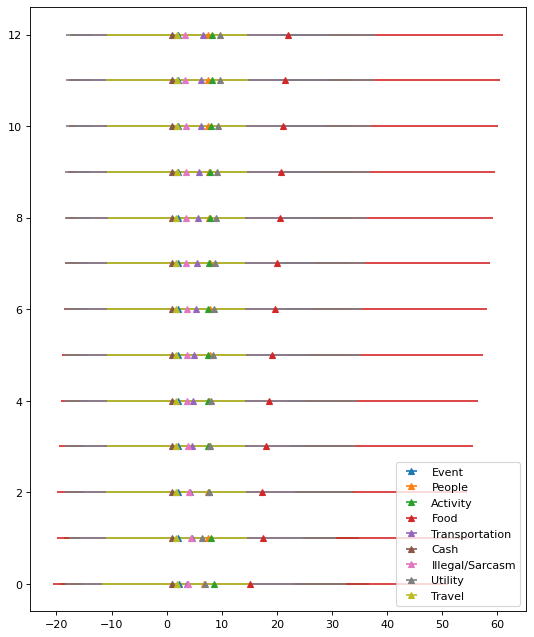

In [ ]:
fig = plt.figure()
figure(figsize=(8, 10), dpi=80)

plt.errorbar(df['avg(Event)'], df.ranking, xerr=df['stddev(Event)'], linestyle='None', marker='^', label = 'Event')
plt.errorbar(df['avg(People)'], df.ranking, xerr=df['stddev(People)'], linestyle='None', marker='^', label = 'People')
plt.errorbar(df['avg(Activity)'], df.ranking, xerr=df['stddev(Activity)'], linestyle='None', marker='^', label = 'Activity')
plt.errorbar(df['avg(Food)'], df.ranking, xerr=df['stddev(Food)'], linestyle='None', marker='^', label = 'Food')
plt.errorbar(df['avg(Transportation)'], df.ranking, xerr=df['stddev(Transportation)'], linestyle='None', marker='^', label = 'Transportation')
plt.errorbar(df['avg(Cash)'], df.ranking, xerr=df['stddev(Cash)'], linestyle='None', marker='^', label = 'Cash')
plt.errorbar(df['avg(Illegal/Sarcasm)'], df.ranking, xerr=df['stddev(Illegal/Sarcasm)'], linestyle='None', marker='^', label = 'Illegal/Sarcasm')
plt.errorbar(df['avg(Utility)'], df.ranking, xerr=df['stddev(Utility)'], linestyle='None', marker='^', label = 'Utility')
plt.errorbar(df['avg(Travel)'], df.ranking, xerr=df['stddev(Travel)'], linestyle='None', marker='^', label = 'Travel')

plt.legend(loc='lower right')

Food is the category that takes up the most pecentage of the profile. The standard deviation for Food category is also the highest, while the standard deviation for cash is the lowest. Over time, some category's average precentage changes and some remains about the same. For example, the average percentage for Cash and Travel has remian the same, while the average percentage for Food and Utility increased.  
From the standard deviations, the spending profile of the average customer tend to stablize over otime for some categories such as Event, but there are also categories, such as Food, where the variation increased over time.

# Q5 [10 pts]: Write a script to find a user’s friends and friends of friends (Friend definition:Auser’s friend is someone who has transacted with theuser,either sending money to the user orreceiving money from the user).Describe your algorithmand calculate its computationalcomplexity. Can you do it better?

In [ ]:
# Load the parquet data
parqdf = spark.read.parquet("/content/gdrive/MyDrive/423 Squad/423/HW4Files/VenmoSample.snappy.parquet")
ParquetTable=parqdf.createOrReplaceTempView("ParquetTable")
parksql = spark.sql("select * from ParquetTable")

In [ ]:
parksql.show()

+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|   user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
| 1218774|1528945|         payment|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|
| 5109483|4782303|         payment|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|
| 4322148|3392963|         payment|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a...|
|  469894|1333620|          charge|2016-06-03 23:34:13|                  🎥|      false|5751b185cd03c9af2...|
| 2960727|3442373|         payment|2016-05-29 23:23:42|                   ⚡|      false|574b178ecd03c9af2...|
| 3977544|2709470|         payment|2016-09-29 22:12:07|          Chipotlaid|      false|57ed2f4723e064eac...|
| 3766386|4

In [ ]:
# Friends of the user
def find_friends(user_id):
    friends_user1 = parksql.select("user1","user2").sort("user1").distinct().where("user1=={}".format(user_id))
    friends_user2 = parksql.select("user2","user1").sort("user2").distinct().where("user2=={}".format(user_id))
    friends = friends_user1.union(friends_user2).distinct().select("user2")
    return friends

In [ ]:
find_friends(2).show()

+------+
| user2|
+------+
|    43|
|191142|
|   220|
+------+



In [ ]:
# Only friends of friends of the user
find_friends_of_friends =spark.sql("with table1 as\
                                  (select distinct user1,user2\
                                  from ((select user1, user2 from ParquetTable) \
                                  union (select user2, user1 from ParquetTable) ))\
                                  select distinct t1.user1 as user1, t2.user2 as user3\
                                  from table1 t1\
                                  left join table1 t2\
                                  on t1.user2= t2.user1\
                                  and t1.user1!=t2.user2\
                                  where t2.user2 is not null\
                                  and t2.user2 not in (select t3.user2 from table1 t3 where t3.user1=t1.user1)\
                                  order by user1, user3")

In [ ]:
find_friends_of_friends.show()

+-----+------+
|user1| user3|
+-----+------+
|    2|     3|
|    2|    10|
|    2|    19|
|    2|    96|
|    2|   629|
|    2|  3565|
|    2| 20530|
|    2| 20639|
|    2| 47104|
|    2| 49778|
|    2| 55895|
|    2| 72106|
|    2| 82697|
|    2|183628|
|    2|276439|
|    2|297967|
|    2|307603|
|    2|316862|
|    2|613769|
|    2|851628|
+-----+------+
only showing top 20 rows



Find friends of users: we calculated all the unique users that had interactions with each user under both circumstances when the user is the money payer and the money receiver. Then we union those two results to get all friends for this user. This algorithm has linear complexity O(N).

Find friends of the friends of users: We created a big table which contains all the transactions from users when they are the money payers and receivers. In the next step, we left joined this table by itself to match the friends of friends to users. For instance, if in table 1, A sent money to B, and in table 2, B sent money to C, then C will be considered as the friends of friends of user A. To achieve this, we merge the two tables by matching the money receivers in table 1 and the money senders in table 2. The complexity for this join algorithm is O(N^2) as the two tables have the same number of records..

# Q6 [20 pts]: Now, that you have the list of each user’s friends and friends of friends, you are inposition to calculate many social network variables.Use the dynamic analysis from before, andcalculate the following social network metrics acrossa user’s lifetime in Venmo (from 0 up to 12 months).

In [ ]:
# Choose useful columns from the transactions dataframe
dynamic_profile = parqdf.filter('transaction_type == "payment"').select('user1','user2','datetime')

In [ ]:
w = Window.partitionBy('user1')
dynamic_profile = dynamic_profile.withColumn('start_date', F.to_date(F.min('datetime').over(w)))

In [ ]:
# Returns a profile number for the transaction according to the month since the startdate

def generate_profile_num(datetime,start_date):
    transaction_date = datetime.date()
    profile_interval = [(start_date + relativedelta(months=+i)) for i in range(0,13)]
    
    # If transaction at start_date then its profile_num is 0, then 1st month is 1, 2nd month is 2...
    # for transactons later than last day of 12 month since start_date, then profile_num is 13 for all
    profile_num = bisect.bisect_left(profile_interval, transaction_date) 
    
    return profile_num

In [ ]:
get_profile_num = F.udf(lambda datetime, start_date: generate_profile_num(datetime, start_date))
dynamic_profile = dynamic_profile.withColumn('profile_num', get_profile_num(F.col('datetime'),F.col('start_date')))

In [ ]:
dynamic_profile_clean = dynamic_profile.where( "profile_num <= 12" )

In [ ]:
dynamic_profile_clean.printSchema()

root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- start_date: date (nullable = true)
 |-- profile_num: string (nullable = true)



In [ ]:
# Write CSV
#social_networks = dynamic_profile_clean.orderBy('user1',"user2").select("*").toPandas()

In [ ]:
#Write CSV
#result_pdf.to_csv('/content/gdrive/MyDrive/423 Squad/423/HW4Files/social_network.csv')

In [ ]:
social_networks = spark.read.csv('/content/gdrive/MyDrive/423 Squad/423/HW4Files/social_network.csv', header=True)

In [ ]:
social_networks.show(5)

+---+-----+-------+-------------------+----------+-----------+
|_c0|user1|  user2|           datetime|start_date|profile_num|
+---+-----+-------+-------------------+----------+-----------+
|  0|    2|    220|2012-11-23 06:03:42|2012-11-23|          0|
|  1|    3|     52|2016-09-22 15:30:09|2016-09-22|          0|
|  2|    3|1079020|2016-10-07 23:37:56|2016-09-22|          1|
|  3|    3|1204190|2016-10-09 01:56:24|2016-09-22|          1|
|  4|    3|2382556|2016-10-06 10:49:45|2016-09-22|          1|
+---+-----+-------+-------------------+----------+-----------+
only showing top 5 rows



## i) Number of friends and number of friends of friends [very easy, 4 pts].

### Number of friends


In [ ]:
ParquetTable1 = social_networks.createOrReplaceTempView("ParquetTable1")

In [ ]:
# number of friends of the users
friends=spark.sql("with table1 as ((select distinct user1,user2, profile_num from ParquetTable1)\
                   union (select distinct user2,user1, profile_num from ParquetTable1))\
                   select distinct user1,user2, profile_num from table1\
                   order by user1, user2, profile_num")

In [ ]:
f1=friends.groupby("user1","profile_num").count()
f2=f1.withColumnRenamed("user1","user").withColumnRenamed("count","friends_count")

In [ ]:
f2.show()

+--------+-----------+-------------+
|    user|profile_num|friends_count|
+--------+-----------+-------------+
|10001475|          1|            1|
|10002282|          0|            1|
|10003139|          1|            1|
| 1000314|          0|            1|
| 1000412|          3|            1|
|10005735|          5|            1|
|10008613|          0|            1|
| 1000890|          9|            1|
|10010800|          2|            1|
| 1001112|          0|            1|
| 1001167|          0|            2|
| 1001209|          4|            1|
| 1001446|          0|            3|
|10015360|          5|            1|
|10018049|          0|            1|
| 1002202|          0|            2|
| 1002262|          9|            1|
| 1002303|         11|            1|
| 1002432|          0|            1|
| 1003057|          0|            1|
+--------+-----------+-------------+
only showing top 20 rows



In [ ]:
# Write CSV
#num_friends = f2.coalesce(1).write.csv("/content/gdrive/MyDrive/423 Squad/423/HW4Files/num_friends.csv",header=True) 

In [ ]:
num_friends = spark.read.csv('/content/gdrive/MyDrive/423 Squad/423/HW4Files/num_friends.csv', header=True)

In [ ]:
num_friends.show()

+-------+-----------+-------------+
|   user|profile_num|friends_count|
+-------+-----------+-------------+
|1009555|          0|            1|
|1026850|          3|            2|
|1107152|          3|            1|
|1142389|          2|            1|
|1145940|         12|            1|
|1325763|          1|            1|
| 134054|          1|            1|
|1398462|          8|            1|
|1410595|          3|            2|
|1527888|          6|            2|
|1530925|          1|            1|
|1542994|          7|            1|
|1581006|          2|            2|
|1704743|         12|            1|
|1715902|          0|            1|
|1781480|          0|            1|
| 185978|          5|            1|
|1862395|          2|            1|
|1864051|          1|            1|
|2057290|          0|            2|
+-------+-----------+-------------+
only showing top 20 rows



### Number of friends of friends

In [ ]:
# only friends of friends of the user
friends_of_friends =spark.sql("with table as \
                              (select distinct user1,user2,profile_num\
                              from ((select user1, user2,profile_num from ParquetTable1) \
                              union (select user2,user1,profile_num from ParquetTable1) ))\
                              select distinct t1.user1 as user1,t2.user2 as user3,t1.profile_num as lifetime_fof\
                              from table t1 left join table t2\
                              on t1.user2=t2.user1\
                              and t1.user1 !=t2.user2\
                              where t2.user2 is not null\
                              and t2.user2 not in (select t3.user2 from table t3 where t3.user1=t1.user1 and t3.profile_num=t1.profile_num)")

In [ ]:
fof= friends_of_friends.groupby("user1","lifetime_fof").count()
fof1 = fof.withColumnRenamed("count","friends_of_friends_count")

In [ ]:
# Write CSV
#fof1 = fof1.coalesce(1).write.csv("/content/gdrive/MyDrive/423 Squad/423/HW4Files/friends_of_friends.csv",header=True) 

In [ ]:
fof1 = spark.read.csv('/content/gdrive/MyDrive/423 Squad/423/HW4Files/friends_of_friends.csv', header=True)

In [ ]:
fof1.show()

+--------+------------+------------------------+
|   user1|lifetime_fof|friends_of_friends_count|
+--------+------------+------------------------+
|10001475|           1|                       3|
|10003139|           1|                       3|
|10005735|           5|                       1|
|10008613|           0|                       6|
| 1000890|           9|                      11|
|10010800|           2|                       4|
| 1001112|           0|                       6|
| 1001167|           0|                       4|
| 1001209|           4|                       5|
| 1001446|           0|                       1|
|10015360|           5|                       4|
| 1002202|           0|                       1|
| 1002262|           9|                       5|
| 1002303|          11|                       7|
| 1002432|           0|                      14|
| 1003057|           0|                       6|
|10031704|           0|                       2|
|10032238|          

## ii) Clustering coefficient of a user's network [easy,6 pts]. (Hint: the easiest way to calculate this is to program it yourselves. Alternatively, you canuse “networkx” python package. The latter approach will slow down your script significantly).

In [ ]:
friends_final=f2.join(fof1,(f2["user"]==fof1["user1"]) & (f2["profile_num"]==fof1["lifetime_fof"]),"left").na.drop()
cluster_coef=friends_final.withColumn("cluster_coef", col("friends_count")/col("friends_of_friends_count"))
cluster_coef = cluster_coef.withColumn("cluster_coef", F.round(cluster_coef["cluster_coef"], 2))

In [ ]:
# Write CSV
#cluster_coef = cluster_coef.coalesce(1).write.csv("/content/gdrive/MyDrive/423 Squad/423/HW4Files/cluster_coef.csv",header=True) 

In [ ]:
cluster_coef = spark.read.csv('/content/gdrive/MyDrive/423 Squad/423/HW4Files/cluster_coef.csv', header=True)

In [ ]:
cluster_coef.sort("user").show()

+--------+-----------+-------------+--------+------------+------------------------+------------+
|    user|profile_num|friends_count|   user1|lifetime_fof|friends_of_friends_count|cluster_coef|
+--------+-----------+-------------+--------+------------+------------------------+------------+
|      10|          6|            1|      10|           6|                       6|        0.17|
|      10|          9|            1|      10|           9|                       6|        0.17|
|      10|          0|            2|      10|           0|                       3|        0.67|
|      10|          2|            2|      10|           2|                       7|        0.29|
|      10|          4|            2|      10|           4|                       7|        0.29|
|      10|         12|            1|      10|          12|                       3|        0.33|
|      10|          1|            1|      10|           1|                       6|        0.17|
|10000027|          6|        

## iii) Calculate the page rank of each user (hard, 10pts). (Hint: First of all, you need to use GraphFrames to do this. Moreover, notice that pagerank is aglobalsocial network metric. Ifyou go ahead and calculate the page rank for eachuser at each of her lifetime points, you willsoon realize it will be a dead end.Can you thinkof a smart way to do this?)

In [ ]:
parqdf1 = spark.read.parquet("/content/gdrive/MyDrive/423 Squad/423/HW4Files/VenmoSample.snappy.parquet")

In [ ]:
users1 = parqdf1.select('user1','user2','datetime')
users2 = parqdf1.select('user2','user1','datetime')
users = users1.unionAll(users2).dropDuplicates()

In [ ]:
users1.createOrReplaceTempView("ParquetTable2")

In [ ]:
users1.sort("datetime").show()

+------+------+-------------------+
| user1| user2|           datetime|
+------+------+-------------------+
| 45688| 25613|2011-11-29 09:21:05|
| 68725| 68746|2011-12-08 03:42:02|
| 66737| 72944|2011-12-15 01:36:48|
| 68725| 68746|2011-12-17 04:25:17|
| 73992| 74755|2011-12-24 09:31:44|
| 93128| 92060|2012-03-10 10:42:12|
| 49778| 60162|2012-04-07 08:32:55|
| 79580| 88582|2012-04-12 05:00:12|
| 69578| 88370|2012-04-12 07:25:16|
| 89917| 89352|2012-04-12 10:32:50|
| 75309|104995|2012-04-12 10:35:20|
| 49732|   347|2012-04-12 11:05:17|
| 62704| 71197|2012-04-12 11:40:34|
| 90144| 84558|2012-04-12 16:20:12|
| 79711| 79173|2012-04-13 03:03:31|
| 82633|  6346|2012-04-13 04:28:04|
| 79072| 55176|2012-04-13 06:13:38|
|100190|100643|2012-04-13 07:30:17|
| 85211| 68994|2012-04-13 07:36:21|
| 46372| 55919|2012-04-13 07:56:10|
+------+------+-------------------+
only showing top 20 rows



In [ ]:
friends_global = spark.sql("select distinct user1, user2, (100*year(datetime)+month(datetime)) as friend_time_label \
                            from ParquetTable2 \
                            order by user1, user2")

In [ ]:
# Check how the dataset looks
friends_global.show()

+-----+-------+-----------------+
|user1|  user2|friend_time_label|
+-----+-------+-----------------+
|    2|    220|           201211|
|    3|     52|           201609|
|    3|1079020|           201610|
|    3|1204190|           201610|
|    3|2382556|           201610|
|    3|7854140|           201610|
|    4| 122744|           201212|
|    4| 125527|           201212|
|    4| 187560|           201506|
|    4| 221578|           201604|
|    4| 968271|           201402|
|    4|9271982|           201603|
|   10|     43|           201212|
|   10|     43|           201303|
|   10|    255|           201303|
|   10|    255|           201211|
|   10|    255|           201301|
|   10|  36523|           201501|
|   10|  71056|           201304|
|   10|3844713|           201601|
+-----+-------+-----------------+
only showing top 20 rows



In [ ]:
# See the upper and lower bound of the target year and months
min_datetime = users.agg({"datetime": "min"}).collect()[0]
print(min_datetime)

Row(min(datetime)=datetime.datetime(2011, 11, 29, 9, 21, 5))


In [ ]:
max_datetime = users.agg({"datetime": "max"}).collect()[0]
print(max_datetime)

Row(max(datetime)=datetime.datetime(2016, 12, 1, 2, 8, 21))


In [ ]:
# Create a list of months for iteration
monthlist = []
for i in range(2011,2017):
  for j in range(1,13):
    monthlist.append(100*i+j)

monthlist = [x for x in monthlist if x > 201110]

In [ ]:
# see how many transactions in each global time period
friends_global.groupBy('friend_time_label').agg(count('user1').alias('num_trans')).orderBy('friend_time_label').show()

+-----------------+---------+
|friend_time_label|num_trans|
+-----------------+---------+
|           201111|        1|
|           201112|        3|
|           201203|        1|
|           201204|      195|
|           201205|      284|
|           201206|      287|
|           201207|      315|
|           201208|      505|
|           201209|      653|
|           201210|      805|
|           201211|     1002|
|           201212|     1182|
|           201301|     1543|
|           201302|     1860|
|           201303|     2474|
|           201304|     3107|
|           201305|     3622|
|           201306|     3610|
|           201307|     4715|
|           201308|     6518|
+-----------------+---------+
only showing top 20 rows



In [ ]:
# Define PageRank Function
def compute_page_rank(monthly_table):
    
    G = nx.Graph()
    rdd = monthly_table[['user1','user2']].rdd
    input_nodes = rdd.map(tuple).collect()
    G.add_edges_from(input_nodes)
    
    pagerank = nx.pagerank(G, max_iter=50)
    return pagerank

In [ ]:
pagerank_lifetime = []

for i in tqdm.tqdm(monthlist):
    month_table = friends_global[friends_global['friend_time_label']==i]
    page_rank = compute_page_rank(month_table)
    pagerank_lifetime.append(page_rank)

100%|██████████| 62/62 [16:17<00:00, 15.77s/it]


In [ ]:
# Combine all the tables
R = Row('user', 'PageRank_201111')
pagerank_full_table = spark.createDataFrame([R(k,v) for k, v in pagerank_lifetime[0].items()])

for i in tqdm.tqdm(range(1,62)):
  col_name = "PageRank_" + str(monthlist[i])
  R = Row('user', col_name)
  if len(pagerank_lifetime[i])!=0:
    dataframe_tojoin = spark.createDataFrame([R(k,v) for k, v in pagerank_lifetime[i].items()])
    pagerank_full_table = pagerank_full_table.join(dataframe_tojoin,['user'],'outer')
  else:
    pass

100%|██████████| 61/61 [04:11<00:00,  4.12s/it]


In [ ]:
# melt the table
from pyspark.sql.functions import array, col, explode, lit, struct
def melt(df, id_vars, value_vars, var_name, value_name):
    """Convert :class:`DataFrame` from wide to long format."""
    _vars_and_vals = F.array(*[F.struct(F.lit(c).alias(var_name), F.col(c).alias(value_name)) for c in value_vars])
    # Add to the DataFrame and explode
    _tmp = df.withColumn("_vars_and_vals", F.explode(_vars_and_vals))
    cols = id_vars + [F.col("_vars_and_vals")[x].alias(x) for x in [var_name, value_name]]
    return _tmp.select(*cols)

In [ ]:
page_rank_melt = melt(pagerank_full_table, ['user'],[colname for colname in pagerank_full_table.columns if colname != 'user'],'string_datetime','page_rank')
split_col = pyspark.sql.functions.split(page_rank_melt['string_datetime'], '_')
page_rank_melt = page_rank_melt.withColumn('string_year_month', split_col.getItem(1))
page_rank_melt = page_rank_melt.withColumn('natural_year', col('string_year_month').substr(1,4).cast(IntegerType()))\
                .withColumn('natural_month', col('string_year_month').substr(5,6).cast(IntegerType()))
page_rank_melt.show(2)

+----+---------------+---------+-----------------+------------+-------------+
|user|string_datetime|page_rank|string_year_month|natural_year|natural_month|
+----+---------------+---------+-----------------+------------+-------------+
|  29|PageRank_201111|     null|           201111|        2011|           11|
|  29|PageRank_201112|     null|           201112|        2011|           12|
+----+---------------+---------+-----------------+------------+-------------+
only showing top 2 rows



In [ ]:
# Write CSV
# page_rank_melt.coalesce(1).write.csv("/content/gdrive/MyDrive/423 Squad/423/HW4Files/page_rank.csv",header=True)

# Q7 [5 pt]: First, create your dependent variableY,i.e. the total number of transactions at lifetimepoint 12. In other words, for every user, you needto count how many transactions s/he hadcommitted during her/his twelve months in Venmo.

In [ ]:
# import re
# #import emoji
# import bisect
# import numpy as np
# import pandas as pd
# import seaborn as sns
# from scipy import stats
# from functools import reduce
# from functools import partial
# from collections import Counter
# import matplotlib.pyplot as plt
# from datetime import datetime
# from dateutil.relativedelta import relativedelta
# %matplotlib inline

# # Import Spark SQL related packages
# from pyspark.sql import functions as F
# from pyspark.sql import types as T
# from pyspark.sql import Window
# from pyspark.sql import SparkSession 
# from pyspark.sql import Row
# from pyspark.sql.functions import dayofmonth
# from pyspark.sql.functions import when
# from pyspark.sql.functions import concat_ws
# from pyspark.sql.functions import lit

# # Import Spark MLlib related packages
# from pyspark.ml.feature import Tokenizer
# from pyspark.ml.linalg import Vectors
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import VectorIndexer
# from pyspark.ml.evaluation import RegressionEvaluator

# # Import Spark MLlib model packages
# from pyspark.ml.regression import RandomForestRegressor
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.regression import GeneralizedLinearRegression

# import pyspark as ps
# conf = ps.SparkConf().setMaster("yarn-client").setAppName("sparK-mer")
# conf.set("spark.driver.memory", "15g")
# conf.set("spark.executor.heartbeatInterval","3600s")

In [ ]:
venmo = spark.read.parquet("/content/gdrive/MyDrive/423/HW4Files/VenmoSample.snappy.parquet")

In [ ]:
venmo.show()

+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|   user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
| 1218774|1528945|         payment|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|
| 5109483|4782303|         payment|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|
| 4322148|3392963|         payment|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a...|
|  469894|1333620|          charge|2016-06-03 23:34:13|                  🎥|      false|5751b185cd03c9af2...|
| 2960727|3442373|         payment|2016-05-29 23:23:42|                   ⚡|      false|574b178ecd03c9af2...|
| 3977544|2709470|         payment|2016-09-29 22:12:07|          Chipotlaid|      false|57ed2f4723e064eac...|
| 3766386|4

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql import SQLContext
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [ ]:
from pyspark.sql.functions import lower, col
user1_df = venmo.select(col("user1").alias('user_id'),'transaction_type','datetime')
user2_df = venmo.select(col("user2").alias('user_id'),'transaction_type','datetime')
venmo_individual = user1_df.union(user2_df)

venmo_individual.show(20)
venmo_individual.createOrReplaceTempView("venmo_individual")


+--------+----------------+-------------------+
| user_id|transaction_type|           datetime|
+--------+----------------+-------------------+
| 1218774|         payment|2015-11-27 10:48:19|
| 5109483|         payment|2015-06-17 11:37:04|
| 4322148|         payment|2015-06-19 07:05:31|
|  469894|          charge|2016-06-03 23:34:13|
| 2960727|         payment|2016-05-29 23:23:42|
| 3977544|         payment|2016-09-29 22:12:07|
| 3766386|         payment|2016-05-20 10:31:15|
|  730075|         payment|2016-05-26 04:46:45|
| 5221751|         payment|2016-07-14 22:53:49|
| 6843582|         payment|2016-08-31 10:32:46|
| 5317324|         payment|2016-01-04 09:11:25|
| 1134661|         payment|2015-10-09 01:53:52|
| 4238868|         payment|2015-10-04 08:28:01|
|11719500|         payment|2016-07-07 21:40:39|
| 3625798|         payment|2016-10-16 14:43:41|
|  613908|          charge|2016-05-07 06:42:17|
| 4682257|         payment|2016-02-24 09:14:12|
| 9414481|         payment|2016-04-09 09

In [ ]:
# get start date
venmo_individual_01 = sqlContext.sql("""SELECT t1.user_id, datetime, startdate
                                      FROM venmo_individual t1
                                      LEFT JOIN (SELECT user_id, MIN(datetime) AS startdate
                                                  FROM venmo_individual
                                                  GROUP BY user_id) as t2
                                      ON t1.user_id = t2.user_id
                                      ORDER BY t1.user_id""")


venmo_individual_01.show(10)

venmo_individual_01.createOrReplaceTempView("venmo_individual_01")


+-------+-------------------+-------------------+
|user_id|           datetime|          startdate|
+-------+-------------------+-------------------+
|      2|2012-11-23 06:03:42|2012-11-23 06:03:42|
|      2|2016-09-26 09:56:55|2012-11-23 06:03:42|
|      2|2016-09-07 07:53:16|2012-11-23 06:03:42|
|      2|2016-04-09 09:29:31|2012-11-23 06:03:42|
|      3|2016-10-09 01:56:24|2016-06-27 01:14:37|
|      3|2016-10-29 09:28:07|2016-06-27 01:14:37|
|      3|2016-06-27 01:14:37|2016-06-27 01:14:37|
|      3|2016-10-07 23:37:56|2016-06-27 01:14:37|
|      3|2016-09-22 15:30:09|2016-06-27 01:14:37|
|      3|2016-10-07 08:50:23|2016-06-27 01:14:37|
+-------+-------------------+-------------------+
only showing top 10 rows



In [ ]:
# add a month_in variable by calculating the difference in month between datetime and startdate
# first transaction is considered as one day on venmo
venmo_individual_02 = sqlContext.sql("""SELECT user_id, datetime, startdate, 
                                        FLOOR(CASE WHEN DATEDIFF(datetime, startdate)>30 THEN (1+DATEDIFF(datetime, startdate))/30.0 ELSE 0 END) AS month_in,
                                        1+DATEDIFF(datetime, startdate) days_on_venmo
                                        FROM venmo_individual_01""")


venmo_individual_02.show(10)

venmo_individual_02.createOrReplaceTempView("venmo_individual_02")


+-------+-------------------+-------------------+--------+-------------+
|user_id|           datetime|          startdate|month_in|days_on_venmo|
+-------+-------------------+-------------------+--------+-------------+
|      2|2012-11-23 06:03:42|2012-11-23 06:03:42|       0|            1|
|      2|2016-09-26 09:56:55|2012-11-23 06:03:42|      46|         1404|
|      2|2016-09-07 07:53:16|2012-11-23 06:03:42|      46|         1385|
|      2|2016-04-09 09:29:31|2012-11-23 06:03:42|      41|         1234|
|      3|2016-10-09 01:56:24|2016-06-27 01:14:37|       3|          105|
|      3|2016-10-29 09:28:07|2016-06-27 01:14:37|       4|          125|
|      3|2016-06-27 01:14:37|2016-06-27 01:14:37|       0|            1|
|      3|2016-10-07 23:37:56|2016-06-27 01:14:37|       3|          103|
|      3|2016-09-22 15:30:09|2016-06-27 01:14:37|       2|           88|
|      3|2016-10-07 08:50:23|2016-06-27 01:14:37|       3|          103|
+-------+-------------------+-------------------+--

In [ ]:
venmo_individual_03 = venmo_individual_02.filter(venmo_individual_02.month_in <= 12)

venmo_individual_03.show()

+-------+-------------------+-------------------+--------+-------------+
|user_id|           datetime|          startdate|month_in|days_on_venmo|
+-------+-------------------+-------------------+--------+-------------+
|      2|2012-11-23 06:03:42|2012-11-23 06:03:42|       0|            1|
|      3|2016-09-22 15:30:09|2016-06-27 01:14:37|       2|           88|
|      3|2016-10-07 23:37:56|2016-06-27 01:14:37|       3|          103|
|      3|2016-10-29 09:28:07|2016-06-27 01:14:37|       4|          125|
|      3|2016-07-22 21:16:37|2016-06-27 01:14:37|       0|           26|
|      3|2016-10-06 10:49:45|2016-06-27 01:14:37|       3|          102|
|      3|2016-10-09 03:36:13|2016-06-27 01:14:37|       3|          105|
|      3|2016-10-07 08:50:23|2016-06-27 01:14:37|       3|          103|
|      3|2016-10-09 01:56:24|2016-06-27 01:14:37|       3|          105|
|      3|2016-06-27 01:14:37|2016-06-27 01:14:37|       0|            1|
|      4|2012-12-15 05:51:12|2012-12-03 03:35:53|  

In [ ]:
total_transaction = venmo_individual_03.groupBy('user_id').agg(F.count('datetime').alias('Y'))
total_transaction.show()


+-------+---+
|user_id|  Y|
+-------+---+
|   2866|  1|
|   3918|  2|
|   4935|  1|
|   5300|  4|
|   6620|  1|
|  20735|  1|
|  28170|  2|
|  28759|  3|
|  29054|  2|
|  29894|  1|
|  30903|  4|
|  30970|  1|
|  32396|  1|
|  33602|  2|
|  35820|  2|
|  36525|  3|
|  40653|  3|
|  43714|  4|
|  43935|  5|
|  44022|  1|
+-------+---+
only showing top 20 rows



# Q8 [5 pts]: Create the recency and frequency variables. In CRM, this predictive framework isknown asRFM. Here, you don’t have monetary amounts,so we will focus on justRF. Recencyrefers to the last time a user was active, and frequencyis how often a user uses Venmo in amonth. You need to compute these metrics across auser’s lifetime in Venmo (from 0 up to 12).For example, if a user has used Venmo twice duringher first month in Venmo with the secondtime being on day x, then her recency in month 1 is“30-x” and her frequency is 30/2=15.

In [ ]:
venmo_individual_03.createOrReplaceTempView("venmo_individual_03")

In [ ]:

recency = sqlContext.sql("""SELECT user_id, month_in, 
                            MIN((month_in+1)*30 - days_on_venmo) AS recency
                            FROM venmo_individual_03
                            GROUP BY user_id, month_in
                            """)


recency.show(10)

+-------+--------+-------+
|user_id|month_in|recency|
+-------+--------+-------+
|   2866|       0|     29|
|   3918|       0|     29|
|   4935|       0|     29|
|   5300|       3|      6|
|   5300|       0|     29|
|   5300|       5|      4|
|   6620|       0|     29|
|  20735|       0|     29|
|  28170|       0|     29|
|  28170|       8|     25|
+-------+--------+-------+
only showing top 10 rows



In [ ]:
recency_frequency = venmo_individual_03.groupBy("user_id","month_in").agg((F.count(lit(1))/30).alias("frequency"))
recency_frequency = recency_frequency.join(recency,["user_id","month_in"])

recency_frequency.show()

+-------+--------+-------------------+-------+
|user_id|month_in|          frequency|recency|
+-------+--------+-------------------+-------+
|   1867|       5|0.03333333333333333|     24|
|   2014|      11|0.03333333333333333|     12|
|   2316|       0|0.03333333333333333|     29|
|   2551|       4|0.03333333333333333|     29|
|   2888|       0|0.03333333333333333|     29|
|   3036|       8|0.03333333333333333|     14|
|   5066|       0|0.06666666666666667|     21|
|   6167|       0|0.03333333333333333|     29|
|   6579|       0|0.06666666666666667|     27|
|  20054|       0|0.03333333333333333|     29|
|  20091|       0|0.06666666666666667|      7|
|  20965|       0|0.03333333333333333|     29|
|  21913|       0|0.03333333333333333|     29|
|  23556|       0|0.03333333333333333|     29|
|  23803|       0|0.03333333333333333|     29|
|  25927|       0|0.06666666666666667|      8|
|  26617|       7|0.03333333333333333|      3|
|  26731|       0|0.06666666666666667|     25|
|  28644|    

# Q9 [10 pts]: For each user’s lifetime point, regressrecency and frequency onY. Plot the MSEfor each lifetime point.In other words, your x-axiswill be lifetime in months (0-12), and youry-axis will be the MSE. (Hint: Don’t forget to splityour data into train and test sets).

In [ ]:
q9 = recency_frequency.join(total_transaction, on=['user_id'])
q9.show(10)

+-------+--------+-------------------+-------+---+
|user_id|month_in|          frequency|recency|  Y|
+-------+--------+-------------------+-------+---+
|   2866|       0|0.03333333333333333|     29|  1|
|   3918|       0|0.06666666666666667|     29|  2|
|   4935|       0|0.03333333333333333|     29|  1|
|   5300|       3|0.03333333333333333|      6|  4|
|   5300|       5|0.06666666666666667|      4|  4|
|   5300|       0|0.03333333333333333|     29|  4|
|   6620|       0|0.03333333333333333|     29|  1|
|  20735|       0|0.03333333333333333|     29|  1|
|  28170|       0|0.03333333333333333|     29|  2|
|  28170|       8|0.03333333333333333|     25|  2|
+-------+--------+-------------------+-------+---+
only showing top 10 rows



In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
# create assembler
assembler = VectorAssembler(inputCols = ['recency', 'frequency'], outputCol = 'features')
# call the assembler
output = assembler.transform(q9)
output.show(5)

+-------+--------+-------------------+-------+---+--------------------+
|user_id|month_in|          frequency|recency|  Y|            features|
+-------+--------+-------------------+-------+---+--------------------+
|   2866|       0|0.03333333333333333|     29|  1|[29.0,0.033333333...|
|   3918|       0|0.06666666666666667|     29|  2|[29.0,0.066666666...|
|   4935|       0|0.03333333333333333|     29|  1|[29.0,0.033333333...|
|   5300|       3|0.03333333333333333|      6|  4|[6.0,0.0333333333...|
|   5300|       5|0.06666666666666667|      4|  4|[4.0,0.0666666666...|
+-------+--------+-------------------+-------+---+--------------------+
only showing top 5 rows



In [ ]:
mse_arr = []
for month in range(13):
  trainData, testData = output.filter(col('Month_in')==month).select('features', 'Y').randomSplit([0.7,0.3])
  lrModel = LinearRegression(labelCol = 'Y', featuresCol = 'features')
  lrEstimator = lrModel.fit(trainData)
  testResults = lrEstimator.evaluate(testData)   
  mse_arr.append(testResults.meanSquaredError)

In [ ]:
mse_arr

[10.320268424775957,
 21.78716586481315,
 35.86782107515253,
 24.353771289676793,
 22.299566783330786,
 21.19499058688189,
 21.423015352356806,
 22.27397845486511,
 24.227525466860765,
 22.58976853211837,
 22.06068854649574,
 22.411626021720338,
 22.536930677581754]

Text(0, 0.5, 'MSE')

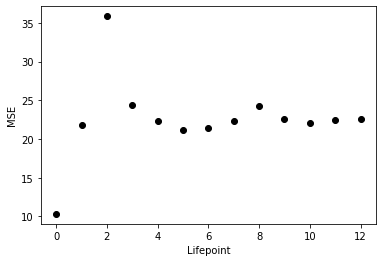

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
Y = list(range(13))

plt.plot(Y,mse_arr, 'o', color='black')
plt.xlabel("Lifepoint")
plt.ylabel("MSE")

# Q10-1 [5 pts]: For each user’s lifetime point, regressrecency, frequencyAND her spendingbehavior profileonY. Plot the MSE for each lifetimepoint like above. Did you get anyimprovement?

## 10-1 Combine Datasets

In [ ]:
# collect spending behavior for first 12 month
venmo_ranking = spark.read.parquet("/content/gdrive/MyDrive/423/HW4Files/venmo_ranking.parquet")
venmo_cat = spark.read.parquet("/content/gdrive/MyDrive/423/venmo_cat.parquet")


In [ ]:

venmo_individual_03.createOrReplaceTempView("venmo_individual_03")
q9.createOrReplaceTempView("q9")

venmo_ranking.createOrReplaceTempView("venmo_ranking")
venmo_cat.createOrReplaceTempView("venmo_cat")

In [ ]:
venmo_cat.show(5)

+----+-------+------------+-------------------+------+----+-----+--------+------+--------------+-------+----+---------------+
|user|ranking|category_all|            profile|People|Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal_Sarcasm|
+----+-------+------------+-------------------+------+----+-----+--------+------+--------------+-------+----+---------------+
| 126|      0|  [Activity]|{'Activity': 100.0}|   0.0| 0.0|  0.0|   100.0|   0.0|           0.0|    0.0| 0.0|            0.0|
| 505|      0|          []|               NONE|   0.0| 0.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|
|2100|      2|          []|               NONE|   0.0| 0.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|
|2544|      2|          []|               NONE|   0.0| 0.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|
|3180|      4|     [Event]|   {'Event': 100.0}|   0.0| 0.0|100.0|     0.0|   0.0|           0.0|    0.0| 0.0|         

In [ ]:
venmo_ranking.show(5)

+----+--------+----------+----+-----+-------------------+----------------+-------+
|user|category|month_rank|year|month|           datetime|transaction_rank|ranking|
+----+--------+----------+----+-----+-------------------+----------------+-------+
|  10|  People|         1|2012|   11|2012-11-25 09:20:39|               1|      0|
|  10|    Food|         2|2012|   12|2012-12-23 11:08:45|               2|      2|
|  10|    null|         2|2012|   12|2012-12-31 12:44:12|               3|      2|
|  10|    Food|         3|2013|    1|2013-01-01 02:26:16|               4|      3|
|  10|Activity|         3|2013|    1|2013-01-14 08:18:43|               5|      3|
+----+--------+----------+----+-----+-------------------+----------------+-------+
only showing top 5 rows



In [ ]:
venmo_cat = venmo_cat.withColumnRenamed("Illegal/Sarcasm","Illegal_Sarcasm")


In [ ]:
# # join spending behavior and recency frequency
# q10 = sqlContext.sql("""SELECT t3.user_id, t3.datetime, t3.month_in, q9.frequency, q9.recency, q9.Y, t2.category_all, t2.profile, t2.People,
#                         t2.Food, t2.Event, t2.Activity, t2.Travel, t2.Transportation, t2.Utility, t2.Cash, t2.Illegal_Sarcasm
                        
#                         FROM venmo_ranking t1
#                         JOIN venmo_cat t2 ON t1.user = t2.user AND t1.ranking = t2.ranking
#                         JOIN venmo_individual_03 t3 ON t1.user = t3.user_id AND t1.datetime = t3.datetime
#                         JOIN q9 ON q9.user_id = t3.user_id AND q9.month_in = t3.month_in
#                             """)

In [ ]:
# join spending behavior and recency frequency
q10_1 = sqlContext.sql("""SELECT t3.user_id, t3.datetime, t3.month_in, q9.frequency, q9.recency, q9.Y

                        FROM venmo_individual_03 t3
                        JOIN q9 ON q9.user_id = t3.user_id AND q9.month_in = t3.month_in
                            """)
q10_1.show()

+-------+-------------------+--------+-------------------+-------+---+
|user_id|           datetime|month_in|          frequency|recency|  Y|
+-------+-------------------+--------+-------------------+-------+---+
|   1867|2015-03-16 00:01:29|       5|0.03333333333333333|     24|  2|
|   2014|2015-07-27 02:55:33|      11|0.03333333333333333|     12|  2|
|   2316|2015-07-20 07:10:33|       0|0.03333333333333333|     29|  2|
|   2551|2016-05-06 21:18:44|       4|0.03333333333333333|     29|  2|
|   2888|2016-03-04 05:45:26|       0|0.03333333333333333|     29|  1|
|   3036|2014-12-16 13:38:29|       8|0.03333333333333333|     14|  5|
|   5066|2013-02-21 11:09:04|       0|0.06666666666666667|     21|  3|
|   5066|2013-02-13 03:13:22|       0|0.06666666666666667|     21|  3|
|   6167|2014-11-09 13:37:35|       0|0.03333333333333333|     29|  4|
|   6579|2016-03-05 07:14:07|       0|0.06666666666666667|     27|  2|
|   6579|2016-03-07 13:01:18|       0|0.06666666666666667|     27|  2|
|  200

In [ ]:
q10_1.createOrReplaceTempView("q10_1")


In [ ]:
venmo_cat.show(5)

+----+-------+------------+-------------------+------+----+-----+--------+------+--------------+-------+----+---------------+
|user|ranking|category_all|            profile|People|Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal_Sarcasm|
+----+-------+------------+-------------------+------+----+-----+--------+------+--------------+-------+----+---------------+
| 126|      0|  [Activity]|{'Activity': 100.0}|   0.0| 0.0|  0.0|   100.0|   0.0|           0.0|    0.0| 0.0|            0.0|
| 505|      0|          []|               NONE|   0.0| 0.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|
|2100|      2|          []|               NONE|   0.0| 0.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|
|2544|      2|          []|               NONE|   0.0| 0.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|
|3180|      4|     [Event]|   {'Event': 100.0}|   0.0| 0.0|100.0|     0.0|   0.0|           0.0|    0.0| 0.0|         

In [ ]:
q10_2 = venmo_cat.join(venmo_ranking, (venmo_cat.user ==  venmo_ranking.user)&(venmo_cat.ranking == venmo_ranking.ranking),"inner").drop(venmo_ranking.user)


In [ ]:
q10_2.show(5)

+----+-------+--------------------+--------------------+---------+---------+---------+--------+------+--------------+-------+----+---------------+--------+----------+----+-----+-------------------+----------------+-------+
|user|ranking|        category_all|             profile|   People|     Food|    Event|Activity|Travel|Transportation|Utility|Cash|Illegal_Sarcasm|category|month_rank|year|month|           datetime|transaction_rank|ranking|
+----+-------+--------------------+--------------------+---------+---------+---------+--------+------+--------------+-------+----+---------------+--------+----------+----+-----+-------------------+----------------+-------+
|  42|      3|[Food, People, Ev...|{'Food': 33.33333...|33.333332|33.333332|33.333332|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|    Food|         3|2012|   12|2012-12-01 11:39:37|               3|      3|
|  42|      3|[Food, People, Ev...|{'Food': 33.33333...|33.333332|33.333332|33.333332|     0.0|   0.0|      

In [ ]:
q10 = q10_1.join(q10_2, (q10_1.user_id ==  q10_2.user)&(q10_1.datetime == q10_2.datetime),"inner").drop(q10_2.user).drop(q10_2.ranking).drop(q10_2.datetime)

In [ ]:
q10.show(5)

+-------+-------------------+--------+-------------------+-------+---+----+-------+------------+-------------------+------+----+-----+--------+------+--------------+-------+----+---------------+--------+----------+----+-----+-------------------+----------------+-------+
|user_id|           datetime|month_in|          frequency|recency|  Y|user|ranking|category_all|            profile|People|Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal_Sarcasm|category|month_rank|year|month|           datetime|transaction_rank|ranking|
+-------+-------------------+--------+-------------------+-------+---+----+-------+------------+-------------------+------+----+-----+--------+------+--------------+-------+----+---------------+--------+----------+----+-----+-------------------+----------------+-------+
|   2337|2016-05-30 17:22:52|       0|0.03333333333333333|     29|  1|2337|      0|          []|               NONE|   0.0| 0.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|         

## 10-1 Prediction

In [ ]:
# create assembler
assembler = VectorAssembler(inputCols = ['recency', 'frequency','People','Food','Event','Activity',
                                         'Travel','Transportation','Utility','Cash','Illegal_Sarcasm'], outputCol = 'features')
# call the assembler
output = assembler.transform(q10)
output.show(5)

+-------+-------------------+--------+-------------------+-------+---+----+-------+------------+-------------------+------+----+-----+--------+------+--------------+-------+----+---------------+--------+----------+----+-----+-------------------+----------------+-------+--------------------+
|user_id|           datetime|month_in|          frequency|recency|  Y|user|ranking|category_all|            profile|People|Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal_Sarcasm|category|month_rank|year|month|           datetime|transaction_rank|ranking|            features|
+-------+-------------------+--------+-------------------+-------+---+----+-------+------------+-------------------+------+----+-----+--------+------+--------------+-------+----+---------------+--------+----------+----+-----+-------------------+----------------+-------+--------------------+
|   2337|2016-05-30 17:22:52|       0|0.03333333333333333|     29|  1|2337|      0|          []|               NONE|   0.0| 

In [ ]:
mse_arr_q10 = []
for month in range(13):
  trainData, testData = output.filter(col('Month_in')==month).select('features', 'Y').randomSplit([0.7,0.3])
  lrModel = LinearRegression(labelCol = 'Y', featuresCol = 'features')
  lrEstimator = lrModel.fit(trainData)
  testResults = lrEstimator.evaluate(testData)   
  mse_arr_q10.append(testResults.meanSquaredError)
  print(mse_arr_q10)

0 : [18.401590813101283]
1 : [18.401590813101283, 33.59113455813533]
2 : [18.401590813101283, 33.59113455813533, 30.301784589633385]
3 : [18.401590813101283, 33.59113455813533, 30.301784589633385, 32.06844914337136]
4 : [18.401590813101283, 33.59113455813533, 30.301784589633385, 32.06844914337136, 159.98853830554557]
5 : [18.401590813101283, 33.59113455813533, 30.301784589633385, 32.06844914337136, 159.98853830554557, 77.89320432038463]
6 : [18.401590813101283, 33.59113455813533, 30.301784589633385, 32.06844914337136, 159.98853830554557, 77.89320432038463, 31.800360865011253]
7 : [18.401590813101283, 33.59113455813533, 30.301784589633385, 32.06844914337136, 159.98853830554557, 77.89320432038463, 31.800360865011253, 31.9359456582155]
8 : [18.401590813101283, 33.59113455813533, 30.301784589633385, 32.06844914337136, 159.98853830554557, 77.89320432038463, 31.800360865011253, 31.9359456582155, 29.599350874356222]
9 : [18.401590813101283, 33.59113455813533, 30.301784589633385, 32.0684491433

In [ ]:
12 : [18.401590813101283, 33.59113455813533, 30.301784589633385, 32.06844914337136, 159.98853830554557, 77.89320432038463, 31.800360865011253, 31.9359456582155, 29.599350874356222, 69.97543357632411, 31.288934512129718, 28.959510617772843, 26.04441276874082]


In [ ]:
mse_arr_q10

[18.401590813101283,
 33.59113455813533,
 30.301784589633385,
 32.06844914337136,
 159.98853830554557,
 77.89320432038463,
 31.800360865011253,
 31.9359456582155,
 29.599350874356222,
 69.97543357632411,
 31.288934512129718,
 28.959510617772843,
 26.04441276874082]

Text(0, 0.5, 'MSE')

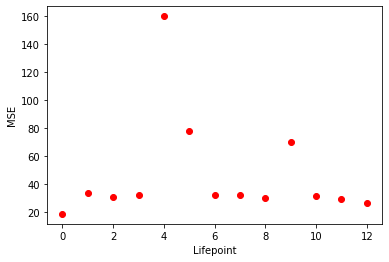

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
Y = list(range(13))

plt.plot(Y,mse_arr_q10, 'o', color='red')
plt.xlabel("Lifepoint")
plt.ylabel("MSE")

# Q10-2 [10 pts]: For each user’s lifetime point, regressher social network metrics onY. Plot theMSE for each lifetime point like above. What do youobserve? How do social networkmetrics compare with the RF framework? What are themost informative predictors?

## 10-2 Combine Datasets

In [ ]:
page_rank = spark.read.csv('/content/gdrive/MyDrive/423 Squad/423/HW4Files/page_rank.csv', header=True)

In [ ]:
page_rank.show()

+----+---------------+---------+-----------------+------------+-------------+
|user|string_datetime|page_rank|string_year_month|natural_year|natural_month|
+----+---------------+---------+-----------------+------------+-------------+
|  29|PageRank_201111|     null|           201111|        2011|           11|
|  29|PageRank_201112|     null|           201112|        2011|           12|
|  29|PageRank_201203|     null|           201203|        2012|            3|
|  29|PageRank_201204|     null|           201204|        2012|            4|
|  29|PageRank_201205|     null|           201205|        2012|            5|
|  29|PageRank_201206|     null|           201206|        2012|            6|
|  29|PageRank_201207|     null|           201207|        2012|            7|
|  29|PageRank_201208|     null|           201208|        2012|            8|
|  29|PageRank_201209|     null|           201209|        2012|            9|
|  29|PageRank_201210|     null|           201210|        2012| 

In [ ]:
cluster_coef = spark.read.csv('/content/gdrive/MyDrive/423 Squad/423/HW4Files/cluster_coef.csv', header=True)

In [ ]:
cluster_coef = cluster_coef.select("user","profile_num","friends_count","friends_of_friends_count","cluster_coef")

In [ ]:
cluster_coef.sort("user").show()

+--------+-----------+-------------+------------------------+------------+
|    user|profile_num|friends_count|friends_of_friends_count|cluster_coef|
+--------+-----------+-------------+------------------------+------------+
|      10|          6|            1|                       6|        0.17|
|      10|          9|            1|                       6|        0.17|
|      10|          0|            2|                       3|        0.67|
|      10|          2|            2|                       7|        0.29|
|      10|          4|            2|                       7|        0.29|
|      10|         12|            1|                       3|        0.33|
|      10|          1|            1|                       6|        0.17|
|10000027|          6|            1|                       3|        0.33|
|10000054|          4|            1|                       1|         1.0|
|10000054|          0|            1|                       3|        0.33|
| 1000006|          0|   

In [ ]:
cluster_coef = cluster_coef.alias("c").join(social_networks.alias("s"), [cluster_coef.user == social_networks.user1, cluster_coef.profile_num == social_networks.profile_num] , how = 'inner')\
                                      .select("c.user", "c.profile_num", "c.friends_count", "c.friends_of_friends_count", "c.cluster_coef", "s.datetime")

In [ ]:
cluster_coef.show()

+--------+-----------+-------------+------------------------+------------+-------------------+
|    user|profile_num|friends_count|friends_of_friends_count|cluster_coef|           datetime|
+--------+-----------+-------------+------------------------+------------+-------------------+
|10001475|          1|            1|                       3|        0.33|2016-08-06 08:51:09|
|10008613|          0|            1|                       6|        0.17|2016-08-27 10:25:17|
| 1001112|          0|            1|                       6|        0.17|2015-11-08 05:14:49|
| 1001167|          0|            2|                       4|         0.5|2015-12-21 15:01:04|
| 1001209|          4|            1|                       5|         0.2|2014-10-25 23:23:21|
| 1001446|          0|            3|                       1|         3.0|2014-08-06 03:13:06|
| 1002202|          0|            2|                       1|         2.0|2014-02-06 03:13:10|
| 1002262|          9|            1|              

In [ ]:
cluster_coef = cluster_coef.withColumn("year", year('datetime'))
cluster_coef = cluster_coef.withColumn("month", month('datetime'))

In [ ]:
cluster_coef.show()

+--------+-----------+-------------+------------------------+------------+-------------------+----+-----+
|    user|profile_num|friends_count|friends_of_friends_count|cluster_coef|           datetime|year|month|
+--------+-----------+-------------+------------------------+------------+-------------------+----+-----+
|10001475|          1|            1|                       3|        0.33|2016-08-06 08:51:09|2016|    8|
|10008613|          0|            1|                       6|        0.17|2016-08-27 10:25:17|2016|    8|
| 1001112|          0|            1|                       6|        0.17|2015-11-08 05:14:49|2015|   11|
| 1001167|          0|            2|                       4|         0.5|2015-12-21 15:01:04|2015|   12|
| 1001209|          4|            1|                       5|         0.2|2014-10-25 23:23:21|2014|   10|
| 1001446|          0|            3|                       1|         3.0|2014-08-06 03:13:06|2014|    8|
| 1002202|          0|            2|          

In [ ]:
coef = cluster_coef.alias("c").join(page_rank.alias("p"), [page_rank.user == cluster_coef.user, 
                                                           page_rank.natural_year == cluster_coef.year, 
                                                           page_rank.natural_month == cluster_coef.month] , how = 'inner')\
                   .select("c.user", "c.profile_num", "c.friends_count", "c.friends_of_friends_count", "c.cluster_coef", "c.datetime", "c.year", "c.month", "p.page_rank")\
                   .dropDuplicates()

In [ ]:
coef.show()

+--------+-----------+-------------+------------------------+------------+-------------------+----+-----+--------------------+
|    user|profile_num|friends_count|friends_of_friends_count|cluster_coef|           datetime|year|month|           page_rank|
+--------+-----------+-------------+------------------------+------------+-------------------+----+-----+--------------------+
|10002971|          0|            1|                       2|         0.5|2016-06-25 13:30:17|2016|    6|1.677511780326477...|
|10007039|          0|            1|                       3|        0.33|2016-08-17 00:08:28|2016|    8|1.020259696015841...|
| 1000846|          7|            1|                       6|        0.17|2015-02-04 02:09:45|2015|    2|3.369495346906605E-6|
|10009706|          0|            1|                       2|         0.5|2016-04-27 00:07:00|2016|    4|8.342643239557187E-7|
|10009727|          3|            2|                       8|        0.25|2016-07-07 08:12:12|2016|    7|2.3949

In [ ]:
# Write CSV
#coef.coalesce(1).write.csv("/content/gdrive/MyDrive/423 Squad/423/HW4Files/page_rank_final.csv",header=True)

In [ ]:
coef = spark.read.csv('/content/gdrive/MyDrive/423 Squad/423/HW4Files/page_rank_final.csv', header=True)

## 10-2 Prediction

In [ ]:
social = spark.read.csv("/content/gdrive/MyDrive/423/HW4Files/page_rank_final.csv",header=True)
social.show(5)

+--------+-----------+-------------+------------------------+------------+-------------------+----+-----+--------------------+
|    user|profile_num|friends_count|friends_of_friends_count|cluster_coef|           datetime|year|month|           page_rank|
+--------+-----------+-------------+------------------------+------------+-------------------+----+-----+--------------------+
|10002971|          0|            1|                       2|         0.5|2016-06-25 13:30:17|2016|    6|1.677511780326477...|
|10007039|          0|            1|                       3|        0.33|2016-08-17 00:08:28|2016|    8|1.020259696015841...|
| 1000846|          7|            1|                       6|        0.17|2015-02-04 02:09:45|2015|    2|3.369495346906605E-6|
|10009706|          0|            1|                       2|         0.5|2016-04-27 00:07:00|2016|    4|8.342643239557187E-7|
|10009727|          3|            2|                       8|        0.25|2016-07-07 08:12:12|2016|    7|2.3949

In [ ]:
q10s = social.join(q9, (social.user ==  q9.user_id)&(social.profile_num == q9.month_in),"inner")

q10s.show(5)

+-----+-----------+-------------+------------------------+------------+-------------------+----+-----+--------------------+-------+--------+-------------------+-------+---+
| user|profile_num|friends_count|friends_of_friends_count|cluster_coef|           datetime|year|month|           page_rank|user_id|month_in|          frequency|recency|  Y|
+-----+-----------+-------------+------------------------+------------+-------------------+----+-----+--------------------+-------+--------+-------------------+-------+---+
| 2316|          0|            1|                       6|        0.17|2015-07-20 07:10:33|2015|    7|3.437264762192837...|   2316|       0|0.03333333333333333|     29|  2|
| 5066|          0|            2|                       2|         1.0|2013-02-21 11:09:04|2013|    2|3.031221582297666E-4|   5066|       0|0.06666666666666667|     21|  3|
| 6346|         10|            2|                      10|         0.2|2013-02-24 10:58:00|2013|    2|5.398050271697979E-4|   6346|    

In [ ]:
q10s.printSchema()

root
 |-- user: string (nullable = true)
 |-- profile_num: string (nullable = true)
 |-- friends_count: string (nullable = true)
 |-- friends_of_friends_count: string (nullable = true)
 |-- cluster_coef: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- page_rank: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- month_in: decimal(12,0) (nullable = true)
 |-- frequency: double (nullable = true)
 |-- recency: decimal(17,0) (nullable = true)
 |-- Y: long (nullable = false)



In [ ]:
q10s = q10s.withColumn("friends_count", q10s.friends_count.cast('float')).\
      withColumn("friends_of_friends_count", q10s.friends_of_friends_count.cast('float')).\
      withColumn("cluster_coef", q10s.cluster_coef.cast('float')).\
      withColumn("page_rank", q10s.page_rank.cast('float'))


q10s.printSchema()


root
 |-- user: string (nullable = true)
 |-- profile_num: string (nullable = true)
 |-- friends_count: float (nullable = true)
 |-- friends_of_friends_count: float (nullable = true)
 |-- cluster_coef: float (nullable = true)
 |-- datetime: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- page_rank: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- month_in: decimal(12,0) (nullable = true)
 |-- frequency: double (nullable = true)
 |-- recency: decimal(17,0) (nullable = true)
 |-- Y: long (nullable = false)



In [ ]:
# create assembler
assembler = VectorAssembler(inputCols = ['friends_count', 'friends_of_friends_count','cluster_coef','page_rank'], outputCol = 'features')
# call the assembler
output = assembler.transform(q10s)
output.show(5)

+-----+-----------+-------------+------------------------+------------+-------------------+----+-----+------------+-------+--------+-------------------+-------+---+--------------------+
| user|profile_num|friends_count|friends_of_friends_count|cluster_coef|           datetime|year|month|   page_rank|user_id|month_in|          frequency|recency|  Y|            features|
+-----+-----------+-------------+------------------------+------------+-------------------+----+-----+------------+-------+--------+-------------------+-------+---+--------------------+
| 2316|          0|          1.0|                     6.0|        0.17|2015-07-20 07:10:33|2015|    7|3.4372647E-6|   2316|       0|0.03333333333333333|     29|  2|[1.0,6.0,0.170000...|
| 5066|          0|          2.0|                     2.0|         1.0|2013-02-21 11:09:04|2013|    2|3.0312216E-4|   5066|       0|0.06666666666666667|     21|  3|[2.0,2.0,1.0,3.03...|
| 6346|         10|          2.0|                    10.0|         0.2

In [ ]:
mse_arr_q10s = []
coefficients_social_arr_q10s = []

for month in range(13):
  trainData, testData = output.filter(col('Month_in')==month).select('features', 'Y').randomSplit([0.7,0.3])
  lrModel = LinearRegression(labelCol = 'Y', featuresCol = 'features')
  lrEstimator = lrModel.fit(trainData)
  testResults = lrEstimator.evaluate(testData)   
  mse_arr_q10s.append(testResults.meanSquaredError)
  coefficients_social_arr_q10s.append(lrEstimator.coefficients.values)
  print(mse_arr_q10s)

[12.097073430372763]
[12.097073430372763, 41.868966653365014]
[12.097073430372763, 41.868966653365014, 52.487488792927905]
[12.097073430372763, 41.868966653365014, 52.487488792927905, 41.29075785451296]
[12.097073430372763, 41.868966653365014, 52.487488792927905, 41.29075785451296, 50.34377596405748]
[12.097073430372763, 41.868966653365014, 52.487488792927905, 41.29075785451296, 50.34377596405748, 43.89504270459686]
[12.097073430372763, 41.868966653365014, 52.487488792927905, 41.29075785451296, 50.34377596405748, 43.89504270459686, 45.569253103227396]
[12.097073430372763, 41.868966653365014, 52.487488792927905, 41.29075785451296, 50.34377596405748, 43.89504270459686, 45.569253103227396, 48.72028499561946]
[12.097073430372763, 41.868966653365014, 52.487488792927905, 41.29075785451296, 50.34377596405748, 43.89504270459686, 45.569253103227396, 48.72028499561946, 49.59520932277937]
[12.097073430372763, 41.868966653365014, 52.487488792927905, 41.29075785451296, 50.34377596405748, 43.8950427

In [ ]:
# [12.36319827581992, 42.90315926240297, 45.12123982675927, 43.09444847482881, 51.81341960197548, 45.35245456528259, 44.466507985989914, 48.345434933036024, 49.06876523783439, 41.968110013848424, 47.61924184682523]


In [ ]:
coefficients_social_arr_q10s

[array([ 1.85394023e+00,  1.02129843e-03, -9.10693036e-01, -9.25087804e+00]),
 array([ 3.55163933e+00,  2.69494458e-03, -2.62224107e+00,  1.47501730e+03]),
 array([ 2.36543595e+00,  6.34998128e-03, -3.08043126e+00, -9.08666451e+03]),
 array([ 4.02656324e+00,  6.20653940e-03, -2.67183982e+00,  5.89285899e+03]),
 array([ 4.17320254e+00,  5.41049954e-03, -2.67790240e+00,  9.84917378e+03]),
 array([ 4.90278580e+00,  6.73083117e-03, -1.92732662e+00,  1.23470240e+04]),
 array([ 4.94754349e+00,  2.27880277e-03, -2.60655195e+00,  1.40921321e+04]),
 array([ 4.76280269e+00,  3.67474700e-03, -2.24757696e+00,  2.46238544e+04]),
 array([ 5.07230728e+00,  2.58788654e-03, -2.39726637e+00,  1.43535101e+04]),
 array([ 4.82248853e+00,  4.49271342e-03, -2.36673739e+00,  1.59045835e+04]),
 array([ 5.30258266e+00, -9.61780116e-04, -2.00645339e+00,  4.81080752e+04]),
 array([ 4.90867470e+00,  1.62112928e-04, -2.19866654e+00,  4.08131103e+04]),
 array([ 5.18943541e+00, -4.83810963e-03, -1.68940081e+00,  5.02

In [ ]:
mse_arr_q10s

[12.36319827581992,
 42.90315926240297,
 45.12123982675927,
 43.09444847482881,
 51.81341960197548,
 45.35245456528259,
 44.466507985989914,
 48.345434933036024,
 49.06876523783439,
 41.968110013848424,
 47.61924184682523,
 42.454911541193425,
 47.941475734450606]

Text(0, 0.5, 'MSE')

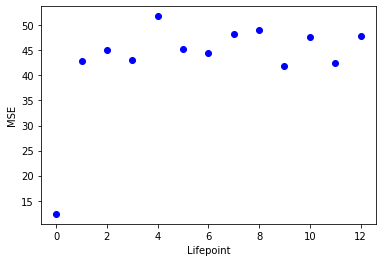

In [ ]:
plt.plot(Y,mse_arr_q10s, 'o', color='blue')
plt.xlabel("Lifepoint")
plt.ylabel("MSE")

# Q11 [10 pts]​: For each user’s lifetime point, regress her social network metrics ​and the spending behavior of her social network​ on ​Y. Plot the MSE for each lifetime point like above. Does the spending behavior of her social network add any predictive benefit compared to Q10?

In [ ]:
cluster_coef = spark.read.csv("/content/drive/MyDrive/423 squad/423/HW4Files/cluster_coef.csv",header= True)
num_friends = spark.read.csv("/content/drive/MyDrive/423 squad/423/HW4Files/num_friends.csv",header= True)
friends_of_friends = spark.read.csv("/content/drive/MyDrive/423 squad/423/HW4Files/friends_of_friends.csv",header= True)
page_rank = spark.read.csv("/content/drive/MyDrive/423 squad/423/HW4Files/page_rank_final.csv",header= True)

In [ ]:
cluster_coef.show(5)

+--------+-----------+-------------+--------+------------+------------------------+------------+
|    user|profile_num|friends_count|   user1|lifetime_fof|friends_of_friends_count|cluster_coef|
+--------+-----------+-------------+--------+------------+------------------------+------------+
|10001475|          1|            1|10001475|           1|                       3|        0.33|
|10003139|          1|            1|10003139|           1|                       3|        0.33|
|10005735|          5|            1|10005735|           5|                       1|         1.0|
|10008613|          0|            1|10008613|           0|                       6|        0.17|
| 1000890|          9|            1| 1000890|           9|                      11|        0.09|
+--------+-----------+-------------+--------+------------+------------------------+------------+
only showing top 5 rows



In [ ]:
cluster_coef.show(5)

+--------+-----------+-------------+------------+------------------------+------------+
|    user|profile_num|friends_count|lifetime_fof|friends_of_friends_count|cluster_coef|
+--------+-----------+-------------+------------+------------------------+------------+
|10001475|          1|            1|           1|                       3|        0.33|
|10003139|          1|            1|           1|                       3|        0.33|
|10005735|          5|            1|           5|                       1|         1.0|
|10008613|          0|            1|           0|                       6|        0.17|
| 1000890|          9|            1|           9|                      11|        0.09|
+--------+-----------+-------------+------------+------------------------+------------+
only showing top 5 rows



In [ ]:
cluster_coef.show(5)

+--------+-----------+-------------+------------+------------------------+------------+
|    user|profile_num|friends_count|lifetime_fof|friends_of_friends_count|cluster_coef|
+--------+-----------+-------------+------------+------------------------+------------+
|10001475|          1|            1|           1|                       3|        0.33|
|10003139|          1|            1|           1|                       3|        0.33|
|10005735|          5|            1|           5|                       1|         1.0|
|10008613|          0|            1|           0|                       6|        0.17|
| 1000890|          9|            1|           9|                      11|        0.09|
+--------+-----------+-------------+------------+------------------------+------------+
only showing top 5 rows



In [ ]:
cluster_coef= cluster_coef.drop('user1')

In [ ]:
page_rank= page_rank.select("user","profile_num", 'page_rank')

In [ ]:
page_rank.show(5)

+--------+-----------+--------------------+
|    user|profile_num|           page_rank|
+--------+-----------+--------------------+
|10002971|          0|1.677511780326477...|
|10007039|          0|1.020259696015841...|
| 1000846|          7|3.369495346906605E-6|
|10009706|          0|8.342643239557187E-7|
|10009727|          3|2.394949932941401...|
+--------+-----------+--------------------+
only showing top 5 rows



In [ ]:
 combine= cluster_coef.join(page_rank, on=['user','profile_num'])

In [ ]:
combine= combine.withColumnRenamed('profile_num','month_in')

In [ ]:
combine.show(5)

+--------+--------+-------------+--------+------------+------------------------+------------+--------------------+
|    user|month_in|friends_count|   user1|lifetime_fof|friends_of_friends_count|cluster_coef|           page_rank|
+--------+--------+-------------+--------+------------+------------------------+------------+--------------------+
|10001475|       1|            1|10001475|           1|                       3|        0.33|7.688913651133877E-7|
|10008613|       0|            1|10008613|           0|                       6|        0.17|7.688913651133877E-7|
| 1001112|       0|            1| 1001112|           0|                       6|        0.17|2.173435832567197E-6|
| 1001167|       0|            2| 1001167|           0|                       4|         0.5|5.741114031282693E-6|
| 1001209|       4|            1| 1001209|           4|                       5|         0.2|7.312828163163821...|
+--------+--------+-------------+--------+------------+------------------------+

In [ ]:
combine= combine.select("user","month_in", 'page_rank','friends_count','friends_of_friends_count','cluster_coef')

In [ ]:
combine= combine.withColumnRenamed('user','user_id')

In [ ]:
q10.show(5)

+-------+-------------------+--------+-------------------+-------+---+------------+-------------------+------+----+-----+--------+------+--------------+-------+----+---------------+--------+----------+----+-----+----------------+
|user_id|           datetime|month_in|          frequency|recency|  Y|category_all|            profile|People|Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal_Sarcasm|category|month_rank|year|month|transaction_rank|
+-------+-------------------+--------+-------------------+-------+---+------------+-------------------+------+----+-----+--------+------+--------------+-------+----+---------------+--------+----------+----+-----+----------------+
|   2337|2016-05-30 17:22:52|       0|0.03333333333333333|     30|  1|          []|               NONE|   0.0| 0.0|  0.0|     0.0|   0.0|           0.0|    0.0| 0.0|            0.0|    null|         1|2016|    5|               1|
|   2952|2014-09-12 01:29:10|      10|0.03333333333333333|     14|  5|          

In [ ]:
 combine= combine.join(q10, on=['user_id','month_in'])

In [ ]:
combine = combine.withColumn("friends_count", combine.friends_count.cast('float')).\
      withColumn("friends_of_friends_count", combine.friends_of_friends_count.cast('float')).\
      withColumn("cluster_coef", combine.cluster_coef.cast('float')).\
      withColumn("page_rank", combine.page_rank.cast('float'))

In [ ]:
# create assembler
assembler = VectorAssembler(inputCols = ['recency', 'frequency','People','Food','Event','Activity',
                                         'Travel','Transportation','Utility','Cash','Illegal_Sarcasm',"page_rank", 'friends_count', 'friends_of_friends_count', 'cluster_coef'], outputCol = 'features')
# call the assembler
output = assembler.transform(combine)
output.show(5)

+-------+--------+------------+-------------+------------------------+------------+-------------------+-------------------+-------+---+------------+-----------------+------+-----+-----+--------+------+--------------+-------+----+---------------+--------+----------+----+-----+----------------+--------------------+
|user_id|month_in|   page_rank|friends_count|friends_of_friends_count|cluster_coef|           datetime|          frequency|recency|  Y|category_all|          profile|People| Food|Event|Activity|Travel|Transportation|Utility|Cash|Illegal_Sarcasm|category|month_rank|year|month|transaction_rank|            features|
+-------+--------+------------+-------------+------------------------+------------+-------------------+-------------------+-------+---+------------+-----------------+------+-----+-----+--------+------+--------------+-------+----+---------------+--------+----------+----+-----+----------------+--------------------+
|   5066|       0|3.0312216E-4|          2.0|          

In [ ]:
mse_arr_q11 = []
i = 0
for month in range(13):
  trainData, testData = output.filter(col('Month_in')==month).select('features', 'Y').randomSplit([0.7,0.3])
  lrModel = LinearRegression(labelCol = 'Y', featuresCol = 'features')
  lrEstimator = lrModel.fit(trainData)
  testResults = lrEstimator.evaluate(testData)   
  mse_arr_q11.append(testResults.meanSquaredError)
  i+= 1
  print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13


In [ ]:
mse_arr_q11

[15.091527652606898,
 57.29203227028317,
 45.314595547609876,
 51.17556734154888,
 116.80463004022269,
 121.00298779048772,
 99.4861205820722,
 113.15376010961519,
 50.65284199570936,
 59.6505192235878,
 58.96483542983527,
 51.591136969176254,
 35.72159263096991]

In [ ]:
pd.DataFrame(mse_arr_q11).to_csv('/content/drive/MyDrive/423 squad/423/HW4Files/mse_arr_q11.csv')

Text(0, 0.5, 'MSE')

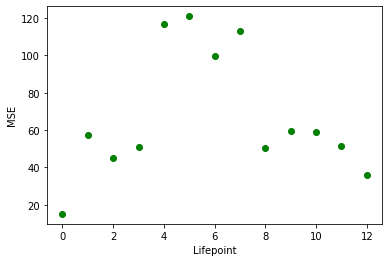

In [ ]:
Y = list(range(13))

plt.plot(Y,mse_arr_q11, 'o', color='green')
plt.xlabel("Lifepoint")
plt.ylabel("MSE")